# Начало

In [1]:
# !pip install scikit-learn[alldeps]

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

In [ ]:
import os
os.environ['SKLEARN_USE_CUDA'] = 'true'

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

## Исходные функции

In [ ]:
# путь до данных на компьютере
path = 'train_data/'

In [6]:
# для работающих в Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# path = '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data'

In [8]:
import os
import pandas as pd
import tqdm


def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.notebook.tqdm(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [9]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)


   #здесь должен быть препроцессинг данных


   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

## Дополнительные функции

In [10]:
# !pip install missingno

In [11]:
from IPython.display import display
import missingno as msno
import matplotlib.pyplot as plt

def print_data_info(df):
    display('=== data.shape ===',df.shape)

    display(df.info())
    print('='*80)

    data_info = df.describe().T
    display(data_info[:50])
    display(data_info[50:])
    print('='*80)

    msno.bar(df)


In [12]:
# пока этот вариант проверим
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)
        #здесь должен быть препроцессинг данных
        columns = list(transactions_frame.columns)
        columns.remove('id')

        for column in columns:
            transactions_frame[column] = transactions_frame[column].astype(np.int8)



        #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

# Чтение данных

## target

In [5]:
# значения целевой переменной (смерджить с фичами по id)
targets = pd.read_csv('train_target.csv')
targets.head()

id  flag
0   0     0
1   1     0
2   2     0
3   3     0
4   4     0

In [6]:
targets.shape

(3000000, 2)

## По блокам

### Чтение 0 - 1

In [ ]:
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=2, num_parts_total=2,
                                    save_to_path='train_data/')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32300\2668831860.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),


Transforming transactions data:   0%|          | 0/1 [00:00<?, ?it/s]

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32300\3059785415.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_0.pq
chunk_path train_data/train_data_1.pq


In [ ]:
# пример полученных данных
c.head()

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm   
0   0   1                18                    9          2          3  \
1   0   2                18                    9         14         14   
2   0   3                18                    9          4          8   
3   0   4                 4                    1          9         12   
4   0   5                 5                   12         15          2   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit   
0               16               10                      11  \
1               12               12                       0   
2                1               11                      11   
3               16                7                      12   
4               11               12                      10   

   pre_loans_next_pay_summ  ...  enc_paym_21  enc_paym_22  enc_paym_23   
0                        3  ...            3            3            3  \
1                        3  ...            0            0            0   
2                        0  ...            0            0            0   
3                        2  ...            3            3            3   
4                        2  ...            3            3            3   

   enc_paym_24  enc_loans_account_holder_type  enc_loans_credit_status   
0            4                              1                        3  \
1            4                              1                        3   
2            4                              1                        2   
3            4                              1                        3   
4            4                              1                        3   

   enc_loans_credit_type  enc_loans_account_cur  pclose_flag  fclose_flag  
0                      4                      1            0            0  
1                      4                      1            0            0  
2                      3                      1            1            1  
3                      1                      1            0            0  
4                      4                      1            0            0  

[5 rows x 61 columns]

In [ ]:
targets.shape

(3000000, 2)

In [ ]:
data.shape

(4082029, 61)

### Чтение 10 - 11

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_10.pq
train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_10.pq
chunk_path train_data/train_data_11.pq


'=== data.shape ==='

(4747002, 61)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4747002 entries, 0 to 4747001
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

None

count          mean            std        min   
id                          4747002.0  2.753015e+06  143477.549112  2500000.0  \
rn                          4747002.0  7.429920e+00       5.569519        1.0   
pre_since_opened            4747002.0  9.539647e+00       5.832933        0.0   
pre_since_confirmed         4747002.0  8.666966e+00       4.855755        0.0   
pre_pterm                   4747002.0  8.361286e+00       5.330289        0.0   
pre_fterm                   4747002.0  8.320328e+00       4.529352        0.0   
pre_till_pclose             4747002.0  7.109846e+00       5.138302        0.0   
pre_till_fclose             4747002.0  8.333270e+00       4.242966        0.0   
pre_loans_credit_limit      4747002.0  9.582437e+00       5.850500        0.0   
pre_loans_next_pay_summ     4747002.0  2.352722e+00       1.281068        0.0   
pre_loans_outstanding       4747002.0  2.982699e+00       0.724111        1.0   
pre_loans_total_overdue     4747002.0  0.000000e+00       0.000000        0.0   
pre_loans_max_overdue_sum   4747002.0  2.002979e+00       0.264822        1.0   
pre_loans_credit_cost_rate  4747002.0  4.859314e+00       3.574199        0.0   
pre_loans5                  4747002.0  5.973254e+00       0.404387        0.0   
pre_loans530                4747002.0  1.587301e+01       1.171854        0.0   
pre_loans3060               4747002.0  5.001492e+00       0.081785        1.0   
pre_loans6090               4747002.0  3.999798e+00       0.024381        1.0   
pre_loans90                 4747002.0  8.004583e+00       0.175268        2.0   
is_zero_loans5              4747002.0  9.243272e-01       0.264474        0.0   
is_zero_loans530            4747002.0  8.303603e-01       0.375316        0.0   
is_zero_loans3060           4747002.0  9.567247e-01       0.203476        0.0   
is_zero_loans6090           4747002.0  9.739518e-01       0.159279        0.0   
is_zero_loans90             4747002.0  9.744965e-01       0.157648        0.0   
pre_util                    4747002.0  1.381358e+01       4.363653        0.0   
pre_over2limit              4747002.0  2.234667e+00       0.858621        0.0   
pre_maxover2limit           4747002.0  1.566469e+01       3.995368        0.0   
is_zero_util                4747002.0  6.948238e-01       0.460482        0.0   
is_zero_over2limit          4747002.0  9.216954e-01       0.268650        0.0   
is_zero_maxover2limit       4747002.0  8.557479e-01       0.351345        0.0   
enc_paym_0                  4747002.0  1.553743e-01       0.617258        0.0   
enc_paym_1                  4747002.0  3.592120e-01       0.911080        0.0   
enc_paym_2                  4747002.0  4.952100e-01       1.064185        0.0   
enc_paym_3                  4747002.0  6.271188e-01       1.177019        0.0   
enc_paym_4                  4747002.0  7.511326e-01       1.262169        0.0   
enc_paym_5                  4747002.0  8.791791e-01       1.332312        0.0   
enc_paym_6                  4747002.0  1.026574e+00       1.394178        0.0   
enc_paym_7                  4747002.0  1.184155e+00       1.440195        0.0   
enc_paym_8                  4747002.0  1.293252e+00       1.461692        0.0   
enc_paym_9                  4747002.0  1.398734e+00       1.474655        0.0   
enc_paym_10                 4747002.0  1.516728e+00       1.480266        0.0   
enc_paym_11                 4747002.0  2.653024e+00       1.474198        1.0   
enc_paym_12                 4747002.0  1.777421e+00       1.457938        0.0   
enc_paym_13                 4747002.0  1.911150e+00       1.427030        0.0   
enc_paym_14                 4747002.0  1.978192e+00       1.406692        0.0   
enc_paym_15                 4747002.0  2.031991e+00       1.387878        0.0   
enc_paym_16                 4747002.0  2.080889e+00       1.368746        0.0   
enc_paym_17                 4747002.0  2.127108e+00       1.348857        0.0   
enc_paym_18                 4747002.0  2.175077e+00       1.326

count      mean       std  min  25%  50%   
enc_paym_20                    4747002.0  3.258822  1.281184  1.0  2.0  4.0  \
enc_paym_21                    4747002.0  2.294203  1.260133  0.0  3.0  3.0   
enc_paym_22                    4747002.0  2.327978  1.238837  0.0  3.0  3.0   
enc_paym_23                    4747002.0  2.363618  1.214953  0.0  3.0  3.0   
enc_paym_24                    4747002.0  3.506289  1.102508  1.0  4.0  4.0   
enc_loans_account_holder_type  4747002.0  1.038463  0.323313  0.0  1.0  1.0   
enc_loans_credit_status        4747002.0  2.692113  0.493374  0.0  2.0  3.0   
enc_loans_credit_type          4747002.0  3.635701  1.052501  0.0  3.0  4.0   
enc_loans_account_cur          4747002.0  1.001366  0.043358  0.0  1.0  1.0   
pclose_flag                    4747002.0  0.151420  0.358457  0.0  0.0  0.0   
fclose_flag                    4747002.0  0.217512  0.412554  0.0  0.0  0.0   

                               75%  max  
enc_paym_20                    4.0  4.0  
enc_paym_21                    3.0  3.0  
enc_paym_22                    3.0  3.0  
enc_paym_23                    3.0  3.0  
enc_paym_24                    4.0  4.0  
enc_loans_account_holder_type  1.0  6.0  
enc_loans_credit_status        3.0  6.0  
enc_loans_credit_type          4.0  7.0  
enc_loans_account_cur          1.0  3.0  
pclose_flag                    0.0  1.0  
fclose_flag                    0.0  1.0

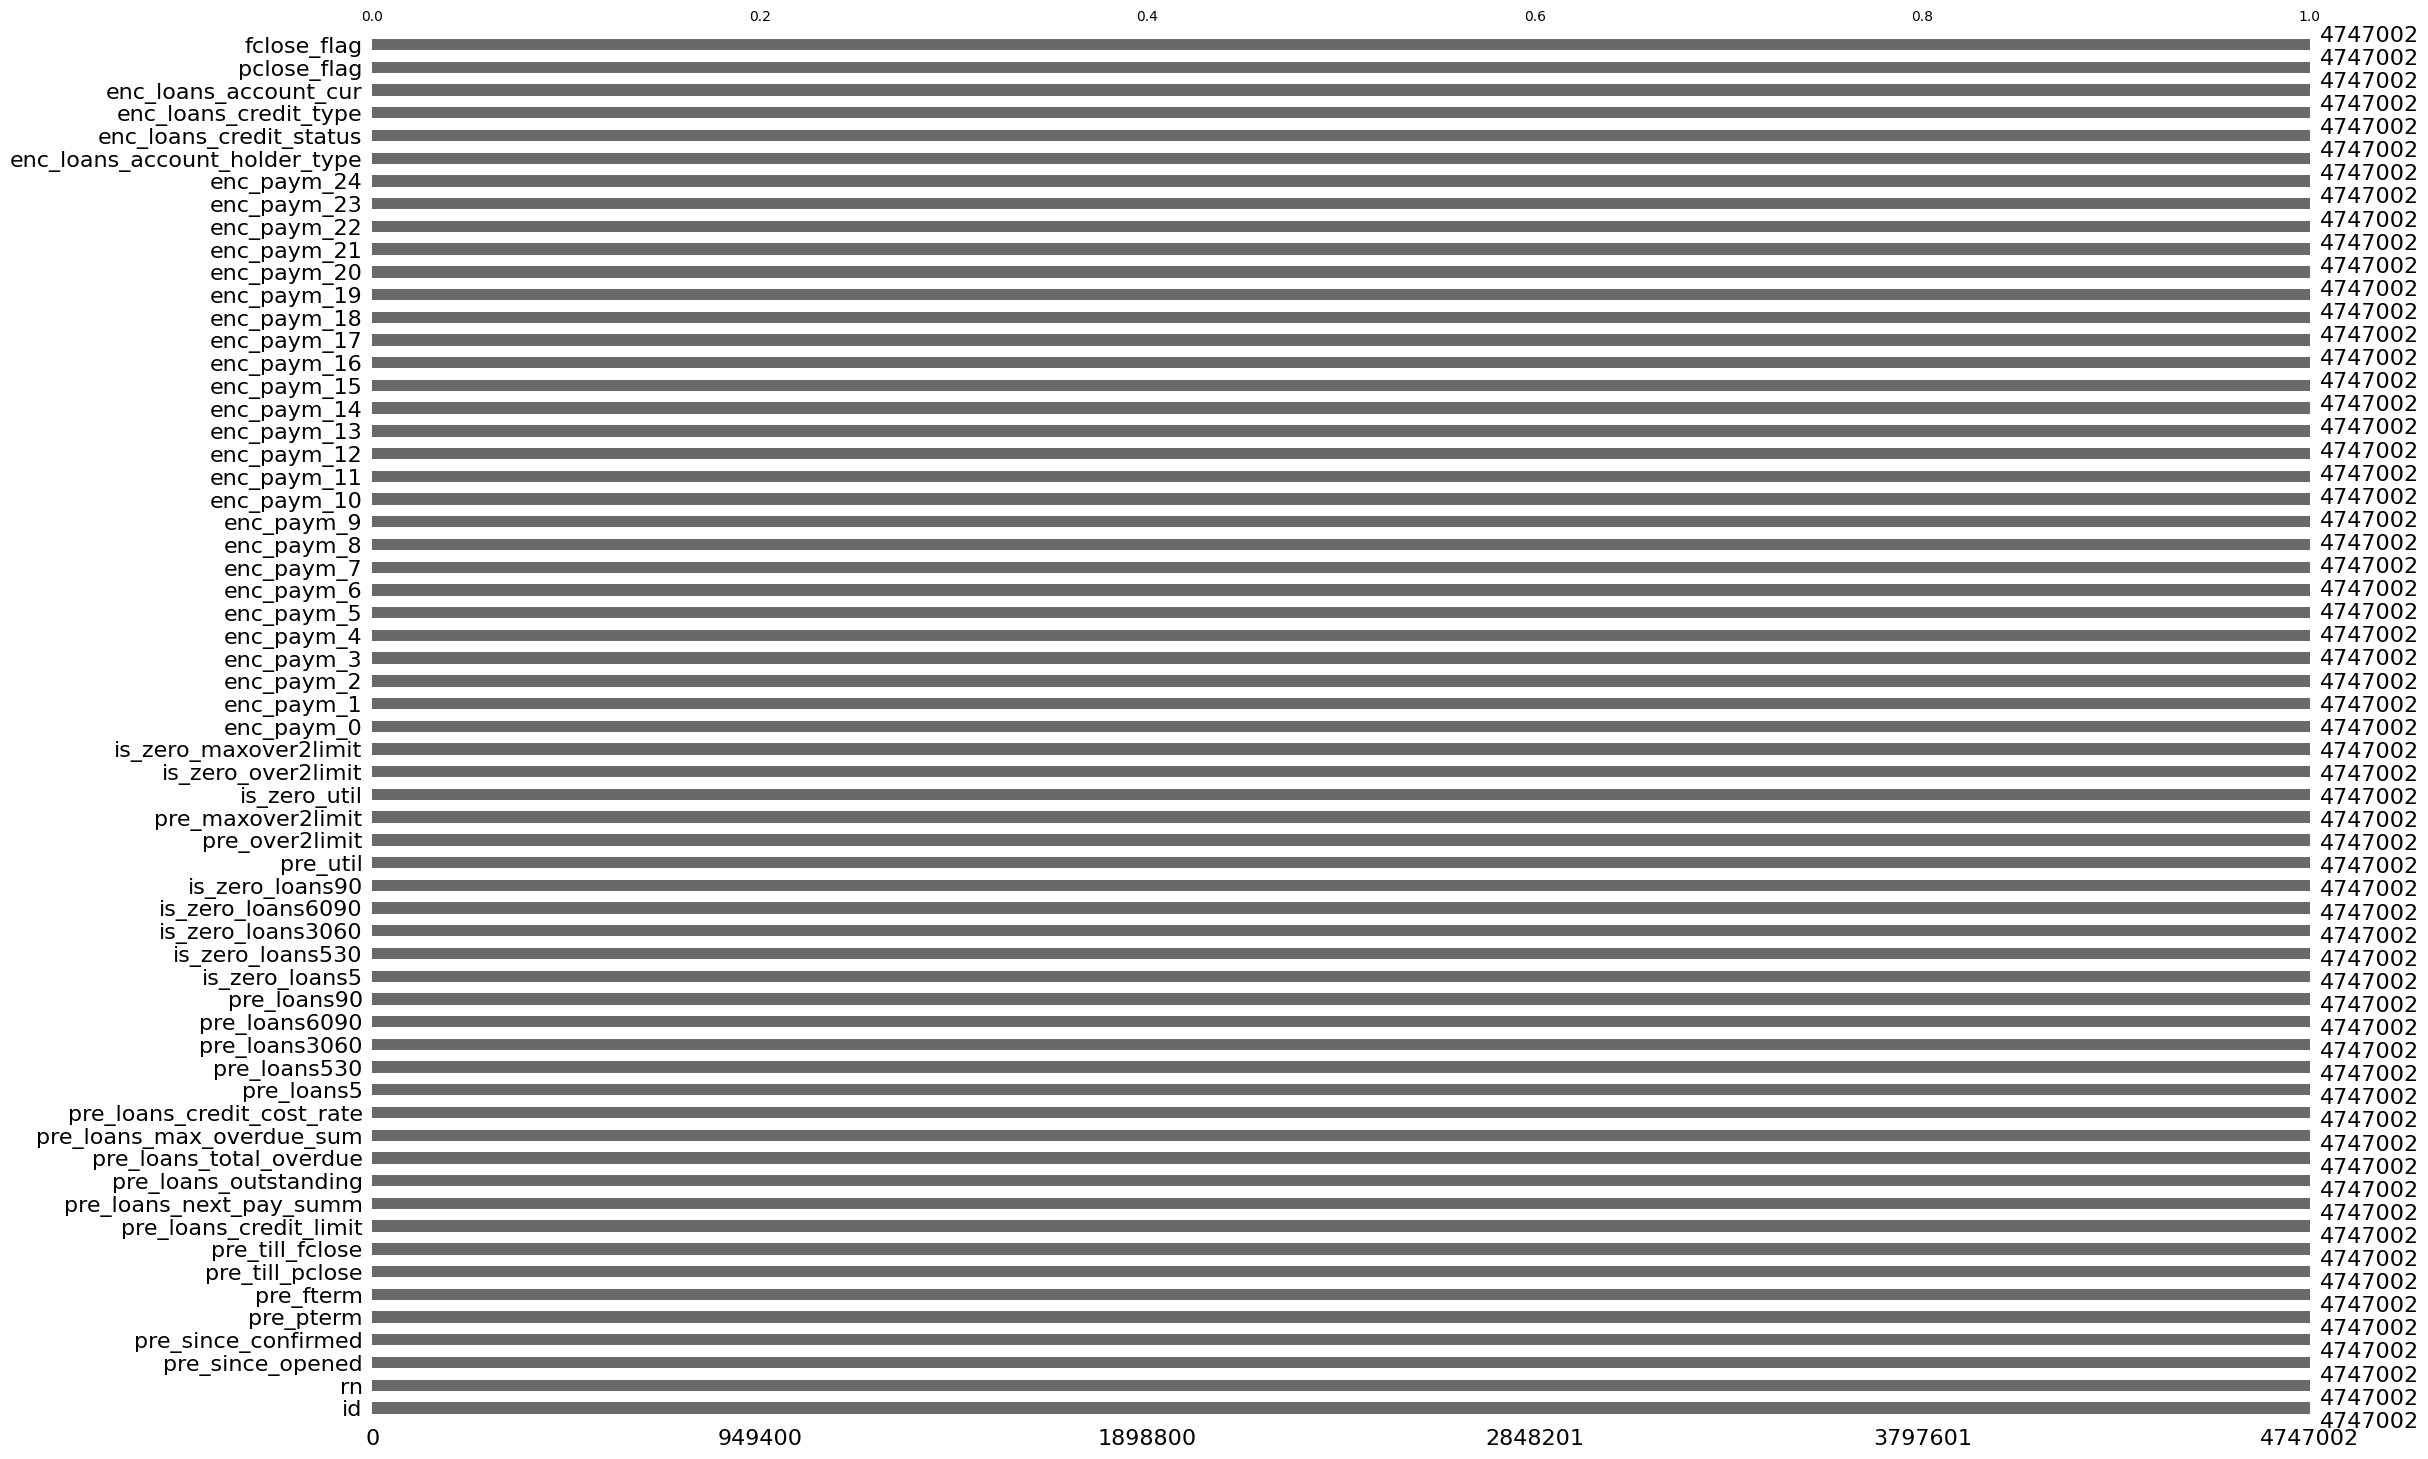

In [ ]:
data = read_parquet_dataset_from_local(path, start_from=2, num_parts_to_read=2, verbose=True)
print_data_info(data)

### 2 - 3

In [ ]:
data = read_parquet_dataset_from_local(path, start_from=4, num_parts_to_read=2, verbose=True)

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_2.pq
train_data/train_data_3.pq


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32300\3059785415.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_2.pq
chunk_path train_data/train_data_3.pq


'=== data.shape ==='

(4193100, 61)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193100 entries, 0 to 4193099
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

None

count           mean            std       min   
id                          4193100.0  750961.393970  144402.317552  500000.0  \
rn                          4193100.0       6.817296       5.269848       1.0   
pre_since_opened            4193100.0       9.286136       5.767455       0.0   
pre_since_confirmed         4193100.0       8.336230       4.621824       0.0   
pre_pterm                   4193100.0       8.387299       5.324562       0.0   
pre_fterm                   4193100.0       8.282716       4.432689       0.0   
pre_till_pclose             4193100.0       7.224657       5.168840       0.0   
pre_till_fclose             4193100.0       8.404432       4.203617       0.0   
pre_loans_credit_limit      4193100.0       9.738865       5.812769       0.0   
pre_loans_next_pay_summ     4193100.0       2.378897       1.336977       0.0   
pre_loans_outstanding       4193100.0       3.005294       0.706054       1.0   
pre_loans_total_overdue     4193100.0       0.000000       0.000000       0.0   
pre_loans_max_overdue_sum   4193100.0       2.007638       0.289506       1.0   
pre_loans_credit_cost_rate  4193100.0       4.607214       3.255262       0.0   
pre_loans5                  4193100.0       5.975973       0.373695       0.0   
pre_loans530                4193100.0      15.881310       1.140813       0.0   
pre_loans3060               4193100.0       5.000906       0.060191       1.0   
pre_loans6090               4193100.0       3.999918       0.015574       1.0   
pre_loans90                 4193100.0       8.001590       0.100031       2.0   
is_zero_loans5              4193100.0       0.909257       0.287243       0.0   
is_zero_loans530            4193100.0       0.843705       0.363135       0.0   
is_zero_loans3060           4193100.0       0.960474       0.194843       0.0   
is_zero_loans6090           4193100.0       0.978824       0.143971       0.0   
is_zero_loans90             4193100.0       0.979436       0.141921       0.0   
pre_util                    4193100.0      13.806504       4.432558       0.0   
pre_over2limit              4193100.0       2.191333       0.819661       0.0   
pre_maxover2limit           4193100.0      15.714349       3.955378       0.0   
is_zero_util                4193100.0       0.697061       0.459529       0.0   
is_zero_over2limit          4193100.0       0.936442       0.243964       0.0   
is_zero_maxover2limit       4193100.0       0.857683       0.349375       0.0   
enc_paym_0                  4193100.0       0.170762       0.635164       0.0   
enc_paym_1                  4193100.0       0.386557       0.941050       0.0   
enc_paym_2                  4193100.0       0.532697       1.096794       0.0   
enc_paym_3                  4193100.0       0.666105       1.203651       0.0   
enc_paym_4                  4193100.0       0.806616       1.292192       0.0   
enc_paym_5                  4193100.0       0.936890       1.356774       0.0   
enc_paym_6                  4193100.0       1.108669       1.418597       0.0   
enc_paym_7                  4193100.0       1.253323       1.452920       0.0   
enc_paym_8                  4193100.0       1.369964       1.469953       0.0   
enc_paym_9                  4193100.0       1.479958       1.477485       0.0   
enc_paym_10                 4193100.0       1.619020       1.474956       0.0   
enc_paym_11                 4193100.0       2.743343       1.461528       1.0   
enc_paym_12                 4193100.0       1.889077       1.431643       0.0   
enc_paym_13                 4193100.0       1.997215       1.398908       0.0   
enc_paym_14                 4193100.0       2.058049       1.376609       0.0   
enc_paym_15                 4193100.0       2.104636       1.357718       0.0   
enc_paym_16                 4193100.0       2.146195       1.339189       0.0   
enc_paym_17                 4193100.0       2.184947       1.320581       0.0   
enc_paym_18                 4193100.0       2.226770       1.29

count      mean       std  min  25%  50%   
enc_paym_20                    4193100.0  3.293601  1.260177  1.0  4.0  4.0  \
enc_paym_21                    4193100.0  2.323340  1.241502  0.0  3.0  3.0   
enc_paym_22                    4193100.0  2.352948  1.221943  0.0  3.0  3.0   
enc_paym_23                    4193100.0  2.385763  1.199047  0.0  3.0  3.0   
enc_paym_24                    4193100.0  3.538175  1.073364  1.0  4.0  4.0   
enc_loans_account_holder_type  4193100.0  1.032703  0.299470  0.0  1.0  1.0   
enc_loans_credit_status        4193100.0  2.686647  0.495483  0.0  2.0  3.0   
enc_loans_credit_type          4193100.0  3.359770  1.063527  0.0  3.0  4.0   
enc_loans_account_cur          4193100.0  1.001893  0.051520  0.0  1.0  1.0   
pclose_flag                    4193100.0  0.144647  0.351745  0.0  0.0  0.0   
fclose_flag                    4193100.0  0.240107  0.427148  0.0  0.0  0.0   

                               75%  max  
enc_paym_20                    4.0  4.0  
enc_paym_21                    3.0  3.0  
enc_paym_22                    3.0  3.0  
enc_paym_23                    3.0  3.0  
enc_paym_24                    4.0  4.0  
enc_loans_account_holder_type  1.0  6.0  
enc_loans_credit_status        3.0  6.0  
enc_loans_credit_type          4.0  5.0  
enc_loans_account_cur          1.0  3.0  
pclose_flag                    0.0  1.0  
fclose_flag                    0.0  1.0

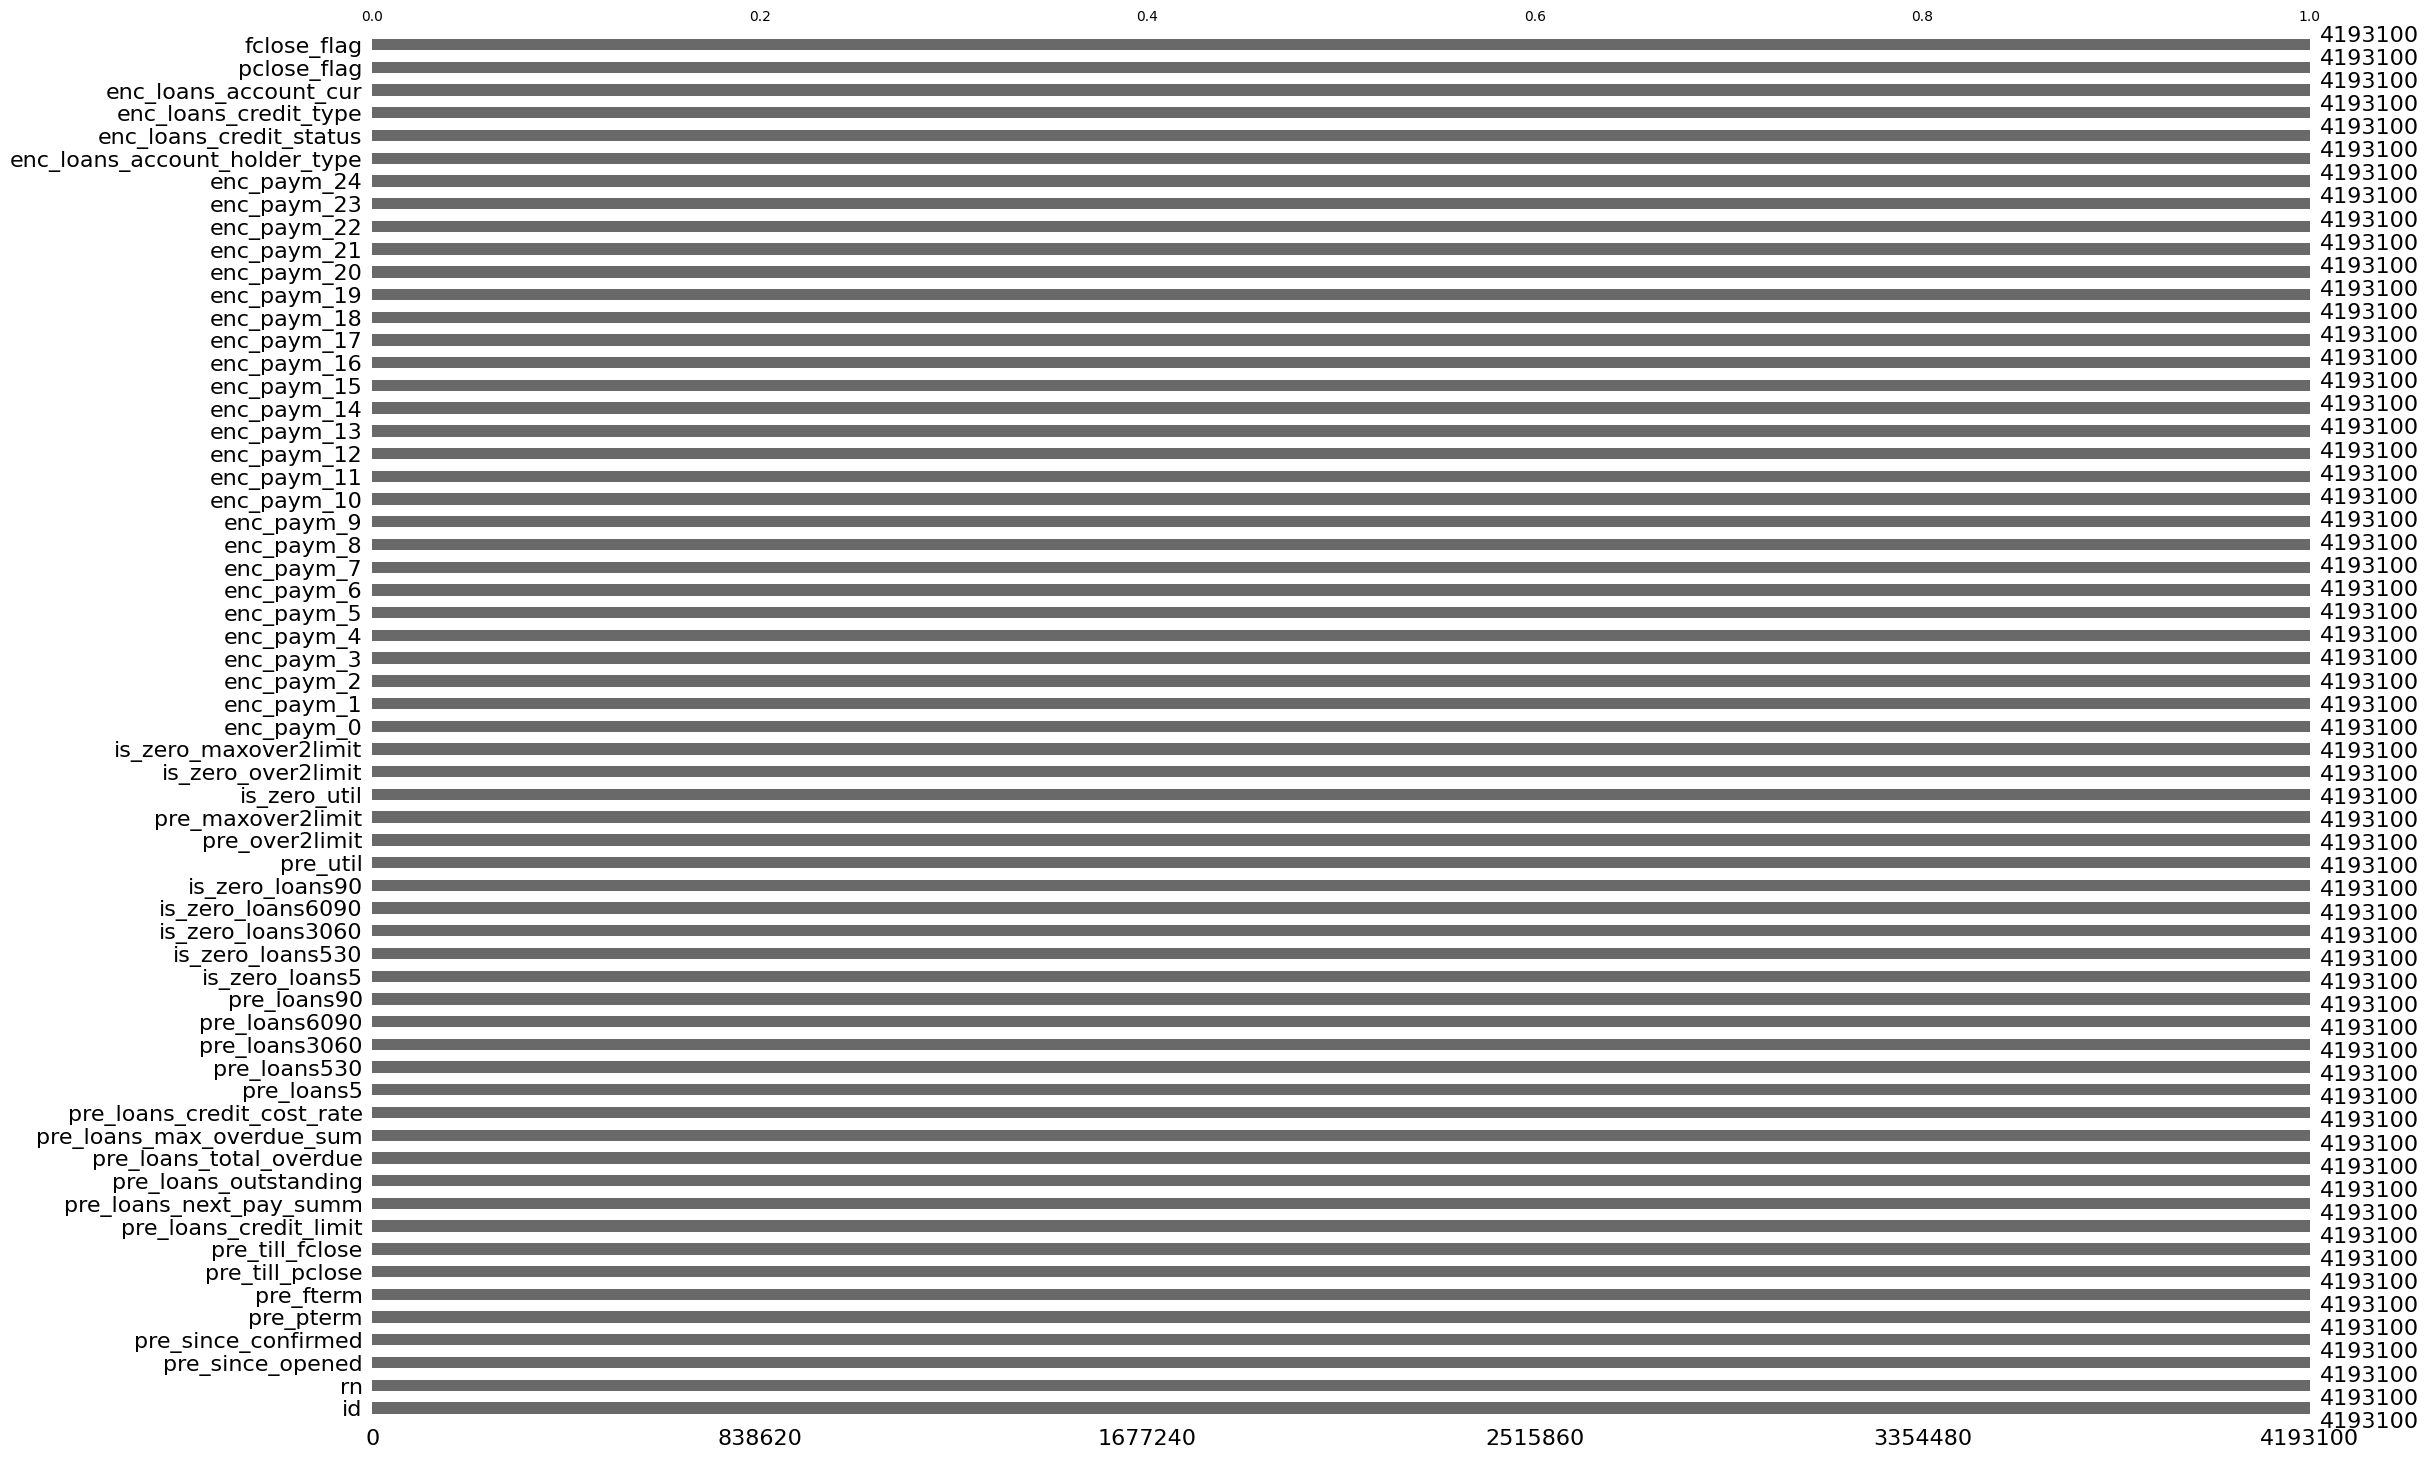

In [ ]:
print_data_info(data)

### 4 - 5

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_4.pq
train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_4.pq
chunk_path train_data/train_data_5.pq


'=== data.shape ==='

(4215018, 61)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4215018 entries, 0 to 4215017
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

None

count          mean            std        min   
id                          4215018.0  1.253039e+06  144982.311152  1000000.0  \
rn                          4215018.0  6.942710e+00       5.352268        1.0   
pre_since_opened            4215018.0  9.318059e+00       5.757131        0.0   
pre_since_confirmed         4215018.0  7.691783e+00       4.694746        0.0   
pre_pterm                   4215018.0  8.352216e+00       5.324116        0.0   
pre_fterm                   4215018.0  8.366175e+00       4.458703        0.0   
pre_till_pclose             4215018.0  7.124207e+00       5.163389        0.0   
pre_till_fclose             4215018.0  8.374670e+00       4.209549        0.0   
pre_loans_credit_limit      4215018.0  9.729443e+00       5.821874        0.0   
pre_loans_next_pay_summ     4215018.0  2.363234e+00       1.316347        0.0   
pre_loans_outstanding       4215018.0  3.000708e+00       0.713868        1.0   
pre_loans_total_overdue     4215018.0  2.372469e-07       0.000487        0.0   
pre_loans_max_overdue_sum   4215018.0  2.002919e+00       0.284260        0.0   
pre_loans_credit_cost_rate  4215018.0  4.525601e+00       3.263015        0.0   
pre_loans5                  4215018.0  5.974522e+00       0.387177        0.0   
pre_loans530                4215018.0  1.586220e+01       1.219683        0.0   
pre_loans3060               4215018.0  5.001460e+00       0.075955        1.0   
pre_loans6090               4215018.0  3.999846e+00       0.021309        1.0   
pre_loans90                 4215018.0  8.004042e+00       0.163643        2.0   
is_zero_loans5              4215018.0  9.244874e-01       0.264217        0.0   
is_zero_loans530            4215018.0  8.216651e-01       0.382794        0.0   
is_zero_loans3060           4215018.0  9.543874e-01       0.208644        0.0   
is_zero_loans6090           4215018.0  9.726974e-01       0.162964        0.0   
is_zero_loans90             4215018.0  9.731652e-01       0.161600        0.0   
pre_util                    4215018.0  1.379231e+01       4.429831        0.0   
pre_over2limit              4215018.0  2.214913e+00       0.902492        0.0   
pre_maxover2limit           4215018.0  1.569917e+01       3.963920        0.0   
is_zero_util                4215018.0  6.922927e-01       0.461545        0.0   
is_zero_over2limit          4215018.0  9.304798e-01       0.254337        0.0   
is_zero_maxover2limit       4215018.0  8.568922e-01       0.350183        0.0   
enc_paym_0                  4215018.0  1.651601e-01       0.634363        0.0   
enc_paym_1                  4215018.0  3.990047e-01       0.952690        0.0   
enc_paym_2                  4215018.0  5.408902e-01       1.101600        0.0   
enc_paym_3                  4215018.0  6.767352e-01       1.209052        0.0   
enc_paym_4                  4215018.0  8.141130e-01       1.294640        0.0   
enc_paym_5                  4215018.0  9.530597e-01       1.361837        0.0   
enc_paym_6                  4215018.0  1.112384e+00       1.418367        0.0   
enc_paym_7                  4215018.0  1.271628e+00       1.454683        0.0   
enc_paym_8                  4215018.0  1.384363e+00       1.470041        0.0   
enc_paym_9                  4215018.0  1.491376e+00       1.476619        0.0   
enc_paym_10                 4215018.0  1.612884e+00       1.474512        0.0   
enc_paym_11                 4215018.0  2.740795e+00       1.461210        1.0   
enc_paym_12                 4215018.0  1.869075e+00       1.436245        0.0   
enc_paym_13                 4215018.0  1.994759e+00       1.399188        0.0   
enc_paym_14                 4215018.0  2.058137e+00       1.375851        0.0   
enc_paym_15                 4215018.0  2.107383e+00       1.355481        0.0   
enc_paym_16                 4215018.0  2.152144e+00       1.335188        0.0   
enc_paym_17                 4215018.0  2.193846e+00       1.314844        0.0   
enc_paym_18                 4215018.0  2.237114e+00       1.291

count      mean       std  min  25%  50%   
enc_paym_20                    4215018.0  3.309524  1.249169  1.0  4.0  4.0  \
enc_paym_21                    4215018.0  2.339431  1.229975  0.0  3.0  3.0   
enc_paym_22                    4215018.0  2.368697  1.210200  0.0  3.0  3.0   
enc_paym_23                    4215018.0  2.399080  1.188635  0.0  3.0  3.0   
enc_paym_24                    4215018.0  3.541295  1.069650  1.0  4.0  4.0   
enc_loans_account_holder_type  4215018.0  1.033617  0.304066  0.0  1.0  1.0   
enc_loans_credit_status        4215018.0  2.695539  0.516232  0.0  2.0  3.0   
enc_loans_credit_type          4215018.0  3.524939  0.955849  0.0  3.0  4.0   
enc_loans_account_cur          4215018.0  1.001708  0.048826  0.0  1.0  1.0   
pclose_flag                    4215018.0  0.151371  0.358410  0.0  0.0  0.0   
fclose_flag                    4215018.0  0.234129  0.423453  0.0  0.0  0.0   

                               75%  max  
enc_paym_20                    4.0  4.0  
enc_paym_21                    3.0  3.0  
enc_paym_22                    3.0  3.0  
enc_paym_23                    3.0  3.0  
enc_paym_24                    4.0  4.0  
enc_loans_account_holder_type  1.0  6.0  
enc_loans_credit_status        3.0  6.0  
enc_loans_credit_type          4.0  7.0  
enc_loans_account_cur          1.0  3.0  
pclose_flag                    0.0  1.0  
fclose_flag                    0.0  1.0

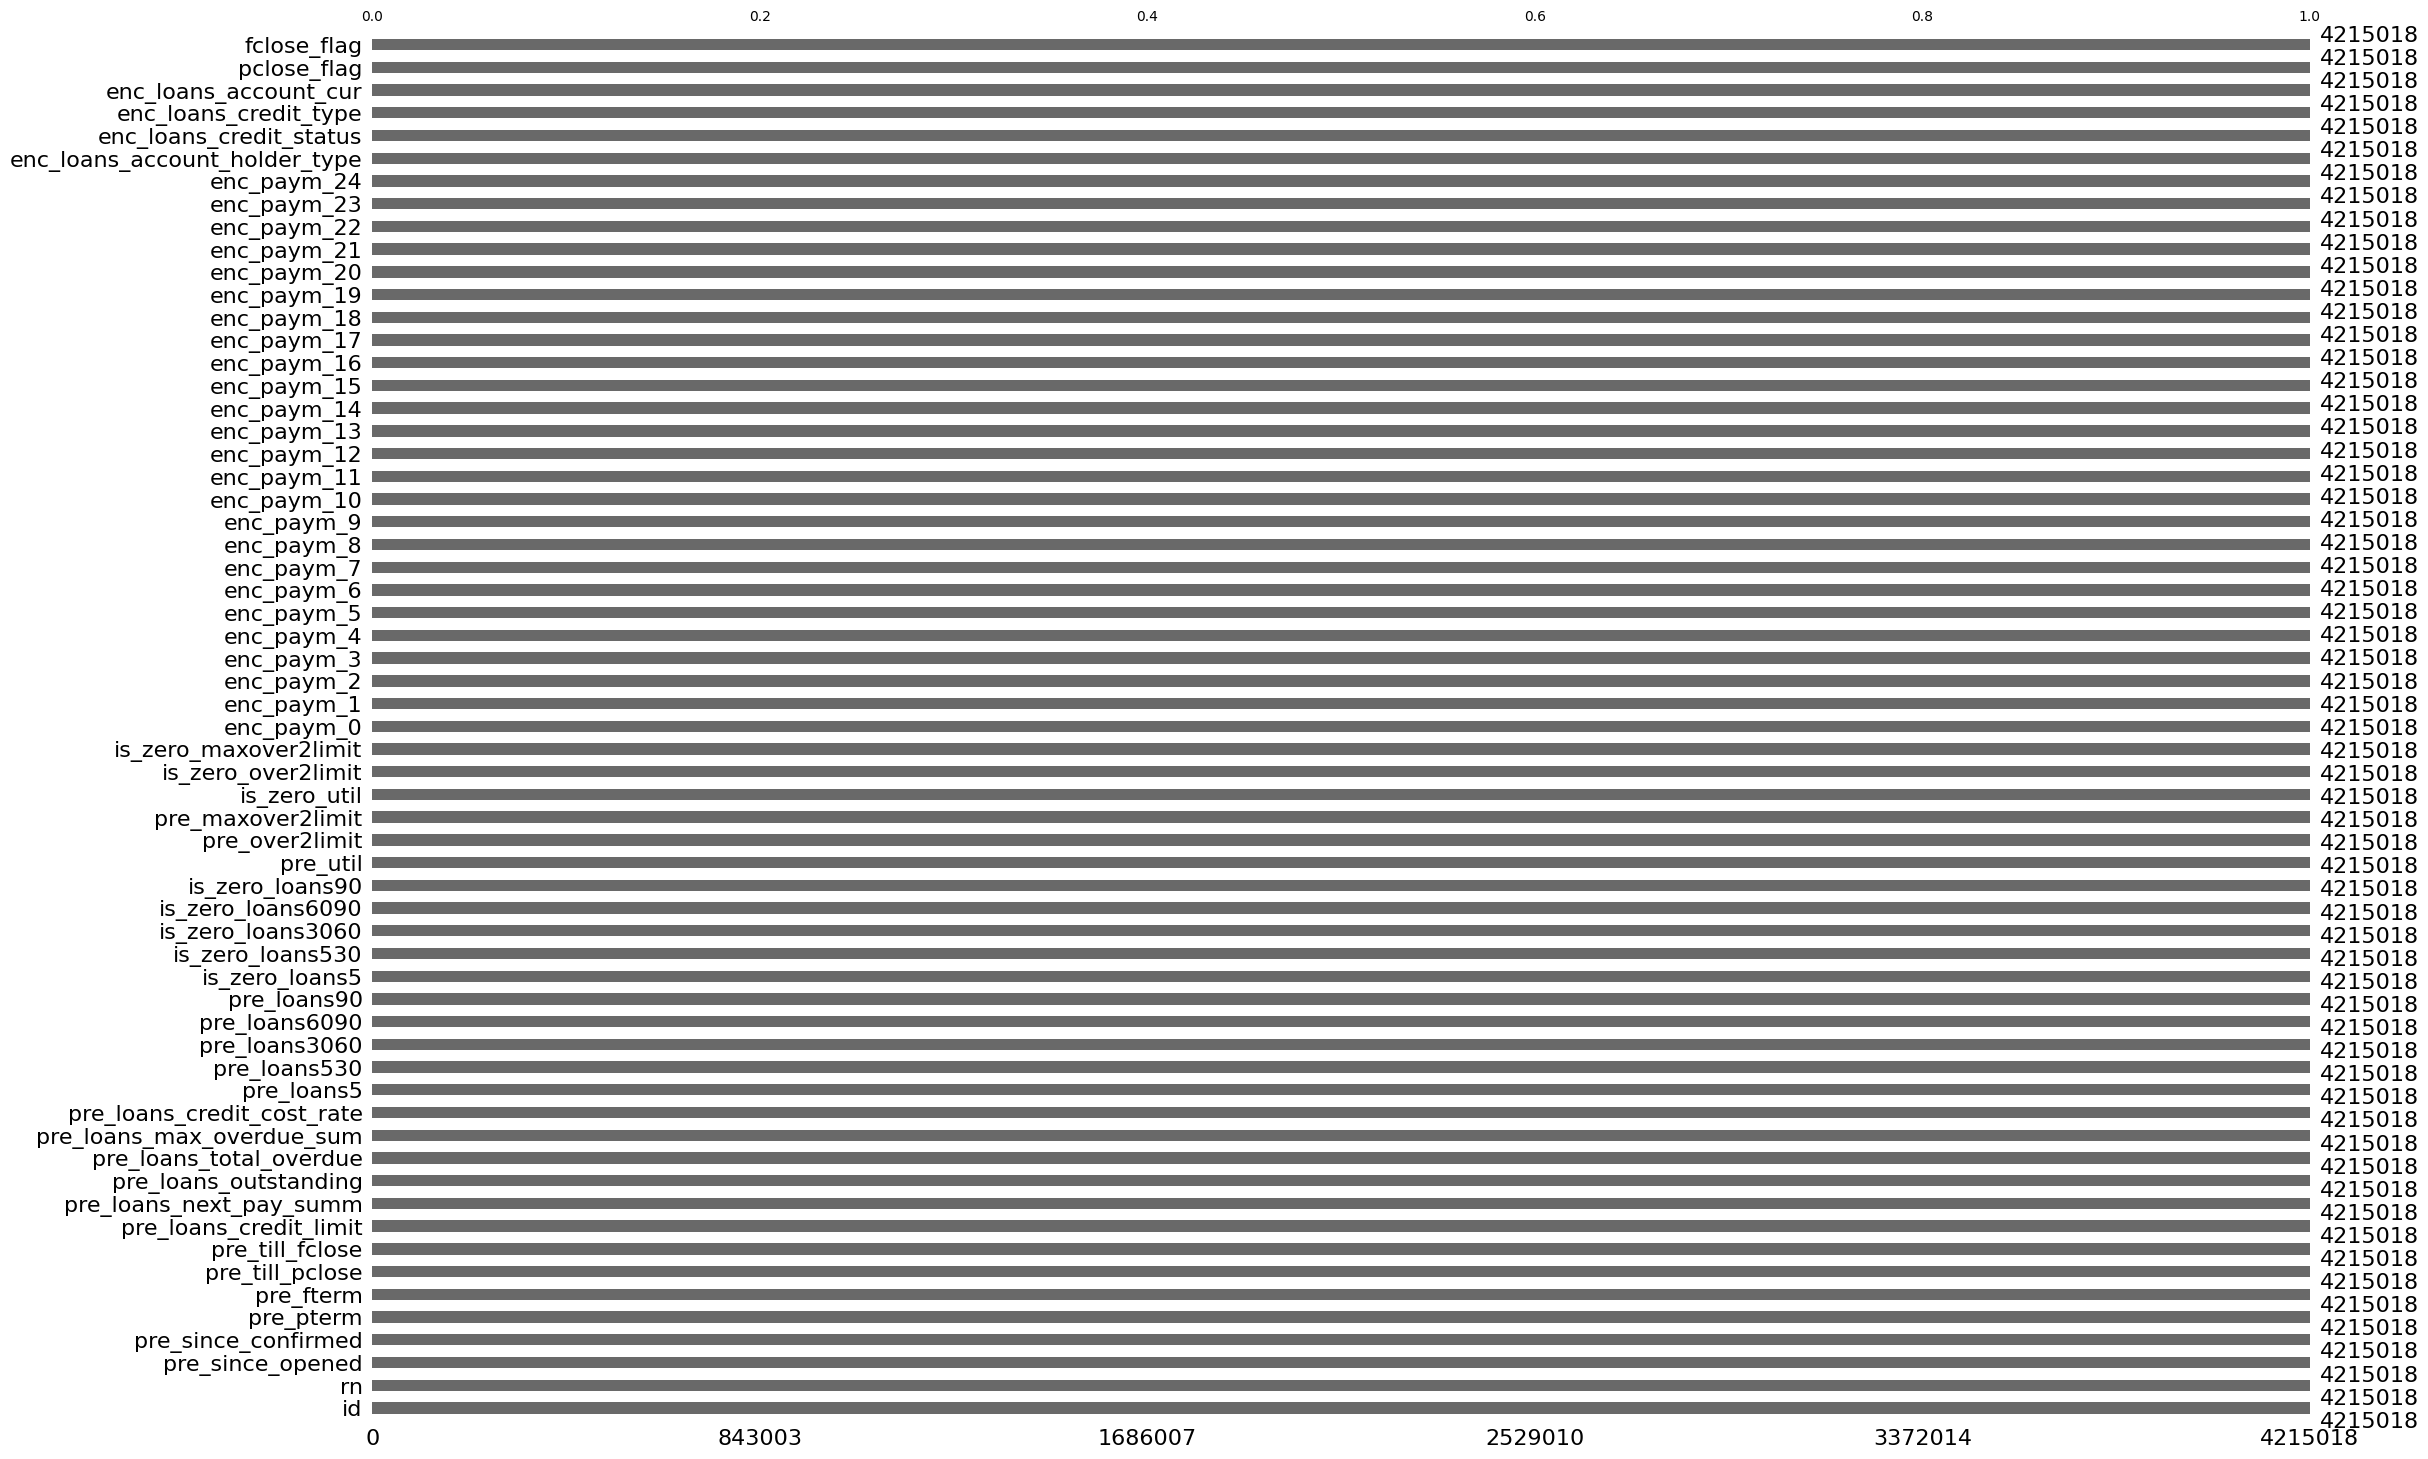

In [ ]:
data = read_parquet_dataset_from_local(path, start_from=6, num_parts_to_read=2, verbose=True)
print_data_info(data)

### 6 - 7

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_6.pq
train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_6.pq
chunk_path train_data/train_data_7.pq


'=== data.shape ==='

(4398697, 61)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398697 entries, 0 to 4398696
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

None

count          mean            std        min   
id                          4398697.0  1.751598e+06  144130.347977  1500000.0  \
rn                          4398697.0  7.101723e+00       5.415055        1.0   
pre_since_opened            4398697.0  9.319304e+00       5.706867        0.0   
pre_since_confirmed         4398697.0  8.175932e+00       4.645277        0.0   
pre_pterm                   4398697.0  8.407916e+00       5.344786        0.0   
pre_fterm                   4398697.0  8.376587e+00       4.489842        0.0   
pre_till_pclose             4398697.0  7.158571e+00       5.137071        0.0   
pre_till_fclose             4398697.0  8.346584e+00       4.224391        0.0   
pre_loans_credit_limit      4398697.0  9.659417e+00       5.831166        0.0   
pre_loans_next_pay_summ     4398697.0  2.347913e+00       1.285958        0.0   
pre_loans_outstanding       4398697.0  2.990745e+00       0.710839        1.0   
pre_loans_total_overdue     4398697.0  0.000000e+00       0.000000        0.0   
pre_loans_max_overdue_sum   4398697.0  2.003828e+00       0.271606        1.0   
pre_loans_credit_cost_rate  4398697.0  4.349567e+00       3.084205        0.0   
pre_loans5                  4398697.0  5.973445e+00       0.398732        0.0   
pre_loans530                4398697.0  1.587008e+01       1.185217        0.0   
pre_loans3060               4398697.0  5.001433e+00       0.077021        0.0   
pre_loans6090               4398697.0  3.999832e+00       0.022323        1.0   
pre_loans90                 4398697.0  8.003895e+00       0.160664        2.0   
is_zero_loans5              4398697.0  9.245906e-01       0.264051        0.0   
is_zero_loans530            4398697.0  8.290223e-01       0.376490        0.0   
is_zero_loans3060           4398697.0  9.571125e-01       0.202603        0.0   
is_zero_loans6090           4398697.0  9.746675e-01       0.157133        0.0   
is_zero_loans90             4398697.0  9.753643e-01       0.155012        0.0   
pre_util                    4398697.0  1.383881e+01       4.368592        0.0   
pre_over2limit              4398697.0  2.218181e+00       0.870987        0.0   
pre_maxover2limit           4398697.0  1.571307e+01       3.939760        0.0   
is_zero_util                4398697.0  6.987888e-01       0.458784        0.0   
is_zero_over2limit          4398697.0  9.281719e-01       0.258203        0.0   
is_zero_maxover2limit       4398697.0  8.602236e-01       0.346755        0.0   
enc_paym_0                  4398697.0  1.603409e-01       0.627077        0.0   
enc_paym_1                  4398697.0  3.830387e-01       0.936918        0.0   
enc_paym_2                  4398697.0  5.164877e-01       1.082465        0.0   
enc_paym_3                  4398697.0  6.425360e-01       1.187421        0.0   
enc_paym_4                  4398697.0  7.706137e-01       1.272742        0.0   
enc_paym_5                  4398697.0  9.039375e-01       1.343044        0.0   
enc_paym_6                  4398697.0  1.057825e+00       1.403830        0.0   
enc_paym_7                  4398697.0  1.220973e+00       1.447398        0.0   
enc_paym_8                  4398697.0  1.335423e+00       1.466726        0.0   
enc_paym_9                  4398697.0  1.446679e+00       1.476727        0.0   
enc_paym_10                 4398697.0  1.570350e+00       1.478156        0.0   
enc_paym_11                 4398697.0  2.704417e+00       1.467485        1.0   
enc_paym_12                 4398697.0  1.832068e+00       1.446034        0.0   
enc_paym_13                 4398697.0  1.963291e+00       1.410534        0.0   
enc_paym_14                 4398697.0  2.027759e+00       1.388496        0.0   
enc_paym_15                 4398697.0  2.077297e+00       1.369330        0.0   
enc_paym_16                 4398697.0  2.122050e+00       1.350234        0.0   
enc_paym_17                 4398697.0  2.164779e+00       1.330390        0.0   
enc_paym_18                 4398697.0  2.209879e+00       1.307

count      mean       std  min  25%  50%   
enc_paym_20                    4398697.0  3.288976  1.262501  1.0  4.0  4.0  \
enc_paym_21                    4398697.0  2.323019  1.241136  0.0  3.0  3.0   
enc_paym_22                    4398697.0  2.356139  1.219209  0.0  3.0  3.0   
enc_paym_23                    4398697.0  2.390091  1.195491  0.0  3.0  3.0   
enc_paym_24                    4398697.0  3.526678  1.083686  1.0  4.0  4.0   
enc_loans_account_holder_type  4398697.0  1.034085  0.303520  0.0  1.0  1.0   
enc_loans_credit_status        4398697.0  2.698586  0.506470  0.0  2.0  3.0   
enc_loans_credit_type          4398697.0  3.608207  1.002116  0.0  3.0  4.0   
enc_loans_account_cur          4398697.0  1.001627  0.047233  0.0  1.0  1.0   
pclose_flag                    4398697.0  0.142428  0.349488  0.0  0.0  0.0   
fclose_flag                    4398697.0  0.226777  0.418747  0.0  0.0  0.0   

                               75%  max  
enc_paym_20                    4.0  4.0  
enc_paym_21                    3.0  3.0  
enc_paym_22                    3.0  3.0  
enc_paym_23                    3.0  3.0  
enc_paym_24                    4.0  4.0  
enc_loans_account_holder_type  1.0  6.0  
enc_loans_credit_status        3.0  6.0  
enc_loans_credit_type          4.0  7.0  
enc_loans_account_cur          1.0  3.0  
pclose_flag                    0.0  1.0  
fclose_flag                    0.0  1.0

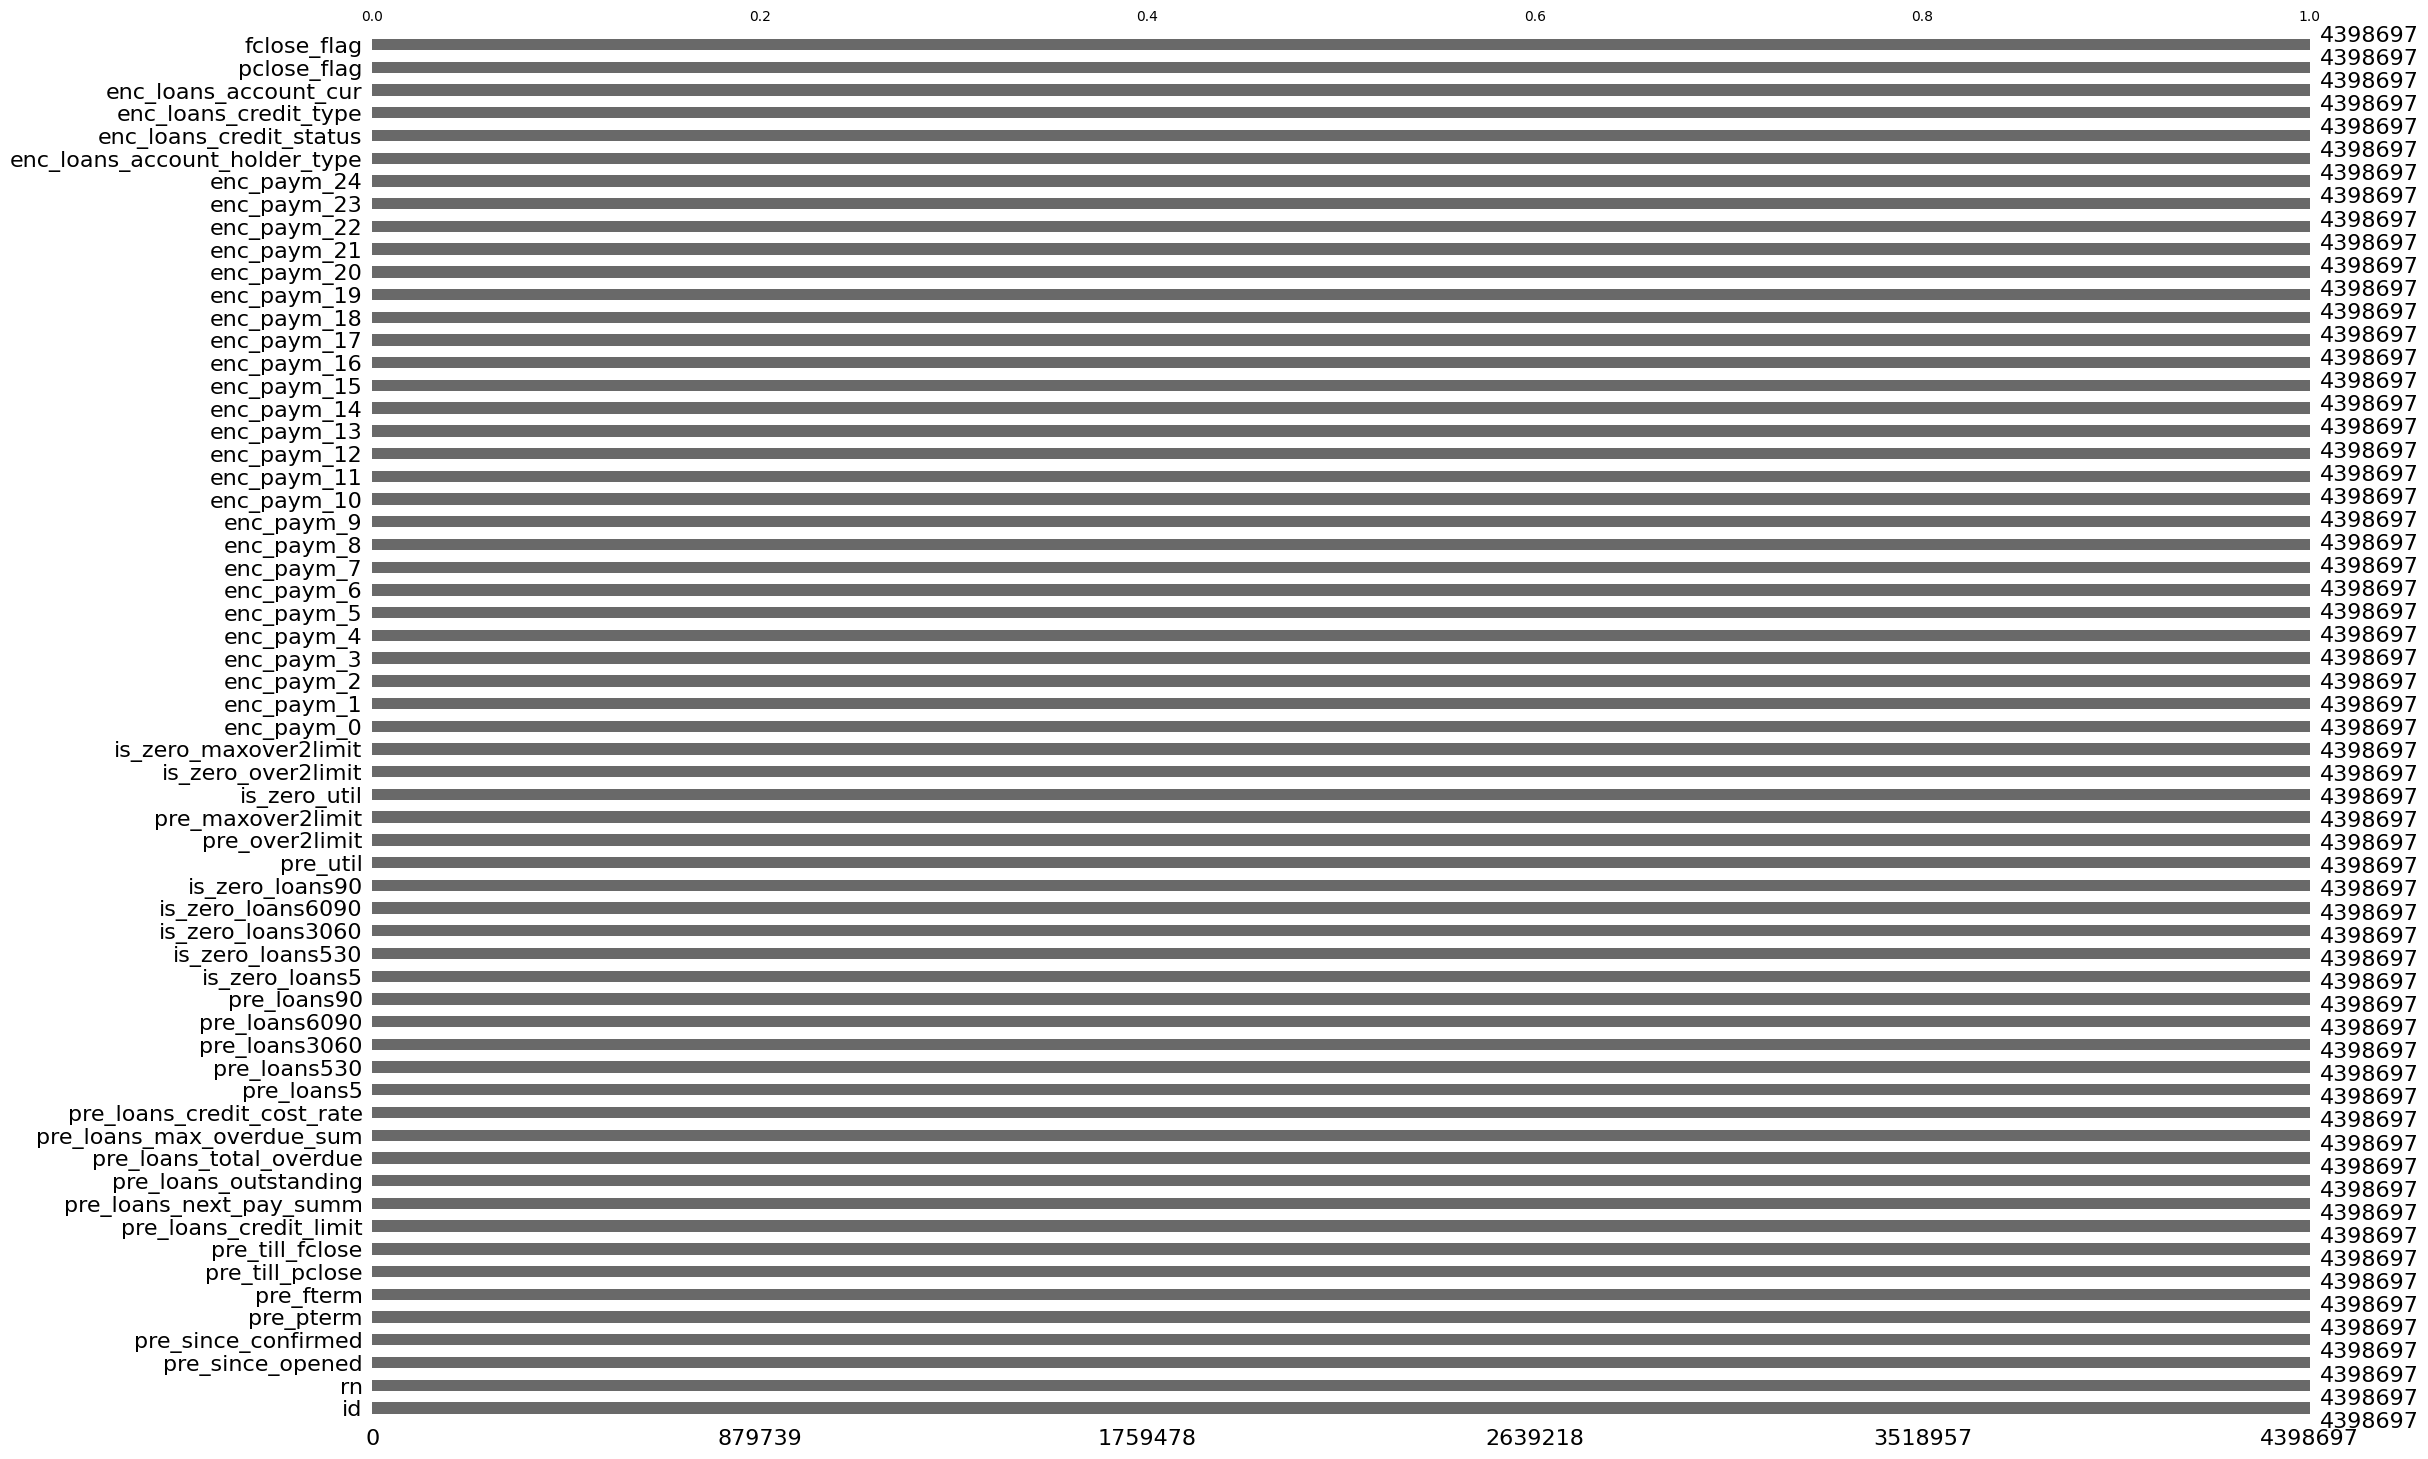

In [ ]:
data = read_parquet_dataset_from_local(path, start_from=8, num_parts_to_read=2, verbose=True)
print_data_info(data)

### 8 - 9

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_8.pq
train_data/train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path train_data/train_data_8.pq
chunk_path train_data/train_data_9.pq


'=== data.shape ==='

(4526871, 61)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4526871 entries, 0 to 4526870
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

None

count          mean            std        min   
id                          4526871.0  2.251120e+06  144620.499777  2000000.0  \
rn                          4526871.0  7.231587e+00       5.487866        1.0   
pre_since_opened            4526871.0  9.419675e+00       5.824621        0.0   
pre_since_confirmed         4526871.0  8.047710e+00       4.691556        0.0   
pre_pterm                   4526871.0  8.379583e+00       5.350037        0.0   
pre_fterm                   4526871.0  8.338565e+00       4.499154        0.0   
pre_till_pclose             4526871.0  7.187806e+00       5.127155        0.0   
pre_till_fclose             4526871.0  8.361411e+00       4.230106        0.0   
pre_loans_credit_limit      4526871.0  9.634916e+00       5.839395        0.0   
pre_loans_next_pay_summ     4526871.0  2.345408e+00       1.274962        0.0   
pre_loans_outstanding       4526871.0  2.988496e+00       0.712400        1.0   
pre_loans_total_overdue     4526871.0  0.000000e+00       0.000000        0.0   
pre_loans_max_overdue_sum   4526871.0  2.004083e+00       0.263711        1.0   
pre_loans_credit_cost_rate  4526871.0  4.717199e+00       3.463363        0.0   
pre_loans5                  4526871.0  5.973291e+00       0.404171        0.0   
pre_loans530                4526871.0  1.587310e+01       1.169660        0.0   
pre_loans3060               4526871.0  5.001480e+00       0.079130        0.0   
pre_loans6090               4526871.0  3.999817e+00       0.023311        0.0   
pre_loans90                 4526871.0  8.004365e+00       0.171360        2.0   
is_zero_loans5              4526871.0  9.240091e-01       0.264984        0.0   
is_zero_loans530            4526871.0  8.317706e-01       0.374070        0.0   
is_zero_loans3060           4526871.0  9.561521e-01       0.204757        0.0   
is_zero_loans6090           4526871.0  9.739710e-01       0.159222        0.0   
is_zero_loans90             4526871.0  9.745087e-01       0.157612        0.0   
pre_util                    4526871.0  1.383327e+01       4.353936        0.0   
pre_over2limit              4526871.0  2.230745e+00       0.877257        0.0   
pre_maxover2limit           4526871.0  1.568329e+01       3.973253        0.0   
is_zero_util                4526871.0  6.972847e-01       0.459433        0.0   
is_zero_over2limit          4526871.0  9.237760e-01       0.265356        0.0   
is_zero_maxover2limit       4526871.0  8.593216e-01       0.347690        0.0   
enc_paym_0                  4526871.0  1.568165e-01       0.619032        0.0   
enc_paym_1                  4526871.0  3.757218e-01       0.929519        0.0   
enc_paym_2                  4526871.0  5.182282e-01       1.084737        0.0   
enc_paym_3                  4526871.0  6.417875e-01       1.187052        0.0   
enc_paym_4                  4526871.0  7.659220e-01       1.270218        0.0   
enc_paym_5                  4526871.0  8.953299e-01       1.339315        0.0   
enc_paym_6                  4526871.0  1.042923e+00       1.399460        0.0   
enc_paym_7                  4526871.0  1.200472e+00       1.443420        0.0   
enc_paym_8                  4526871.0  1.309143e+00       1.463801        0.0   
enc_paym_9                  4526871.0  1.416069e+00       1.475679        0.0   
enc_paym_10                 4526871.0  1.537579e+00       1.479761        0.0   
enc_paym_11                 4526871.0  2.677210e+00       1.471447        1.0   
enc_paym_12                 4526871.0  1.805852e+00       1.452002        0.0   
enc_paym_13                 4526871.0  1.939955e+00       1.418197        0.0   
enc_paym_14                 4526871.0  2.006927e+00       1.396304        0.0   
enc_paym_15                 4526871.0  2.059104e+00       1.376936        0.0   
enc_paym_16                 4526871.0  2.105912e+00       1.357609        0.0   
enc_paym_17                 4526871.0  2.149353e+00       1.337963        0.0   
enc_paym_18                 4526871.0  2.194619e+00       1.315

count      mean       std  min  25%  50%   
enc_paym_20                    4526871.0  3.272849  1.272662  1.0  4.0  4.0  \
enc_paym_21                    4526871.0  2.306316  1.252251  0.0  3.0  3.0   
enc_paym_22                    4526871.0  2.339617  1.230829  0.0  3.0  3.0   
enc_paym_23                    4526871.0  2.374624  1.206894  0.0  3.0  3.0   
enc_paym_24                    4526871.0  3.509334  1.099516  1.0  4.0  4.0   
enc_loans_account_holder_type  4526871.0  1.037003  0.315928  0.0  1.0  1.0   
enc_loans_credit_status        4526871.0  2.692596  0.497929  0.0  2.0  3.0   
enc_loans_credit_type          4526871.0  3.611263  1.037301  0.0  3.0  4.0   
enc_loans_account_cur          4526871.0  1.001529  0.045148  0.0  1.0  1.0   
pclose_flag                    4526871.0  0.139861  0.346843  0.0  0.0  0.0   
fclose_flag                    4526871.0  0.226846  0.418792  0.0  0.0  0.0   

                               75%  max  
enc_paym_20                    4.0  4.0  
enc_paym_21                    3.0  3.0  
enc_paym_22                    3.0  3.0  
enc_paym_23                    3.0  3.0  
enc_paym_24                    4.0  4.0  
enc_loans_account_holder_type  1.0  6.0  
enc_loans_credit_status        3.0  6.0  
enc_loans_credit_type          4.0  7.0  
enc_loans_account_cur          1.0  3.0  
pclose_flag                    0.0  1.0  
fclose_flag                    0.0  1.0

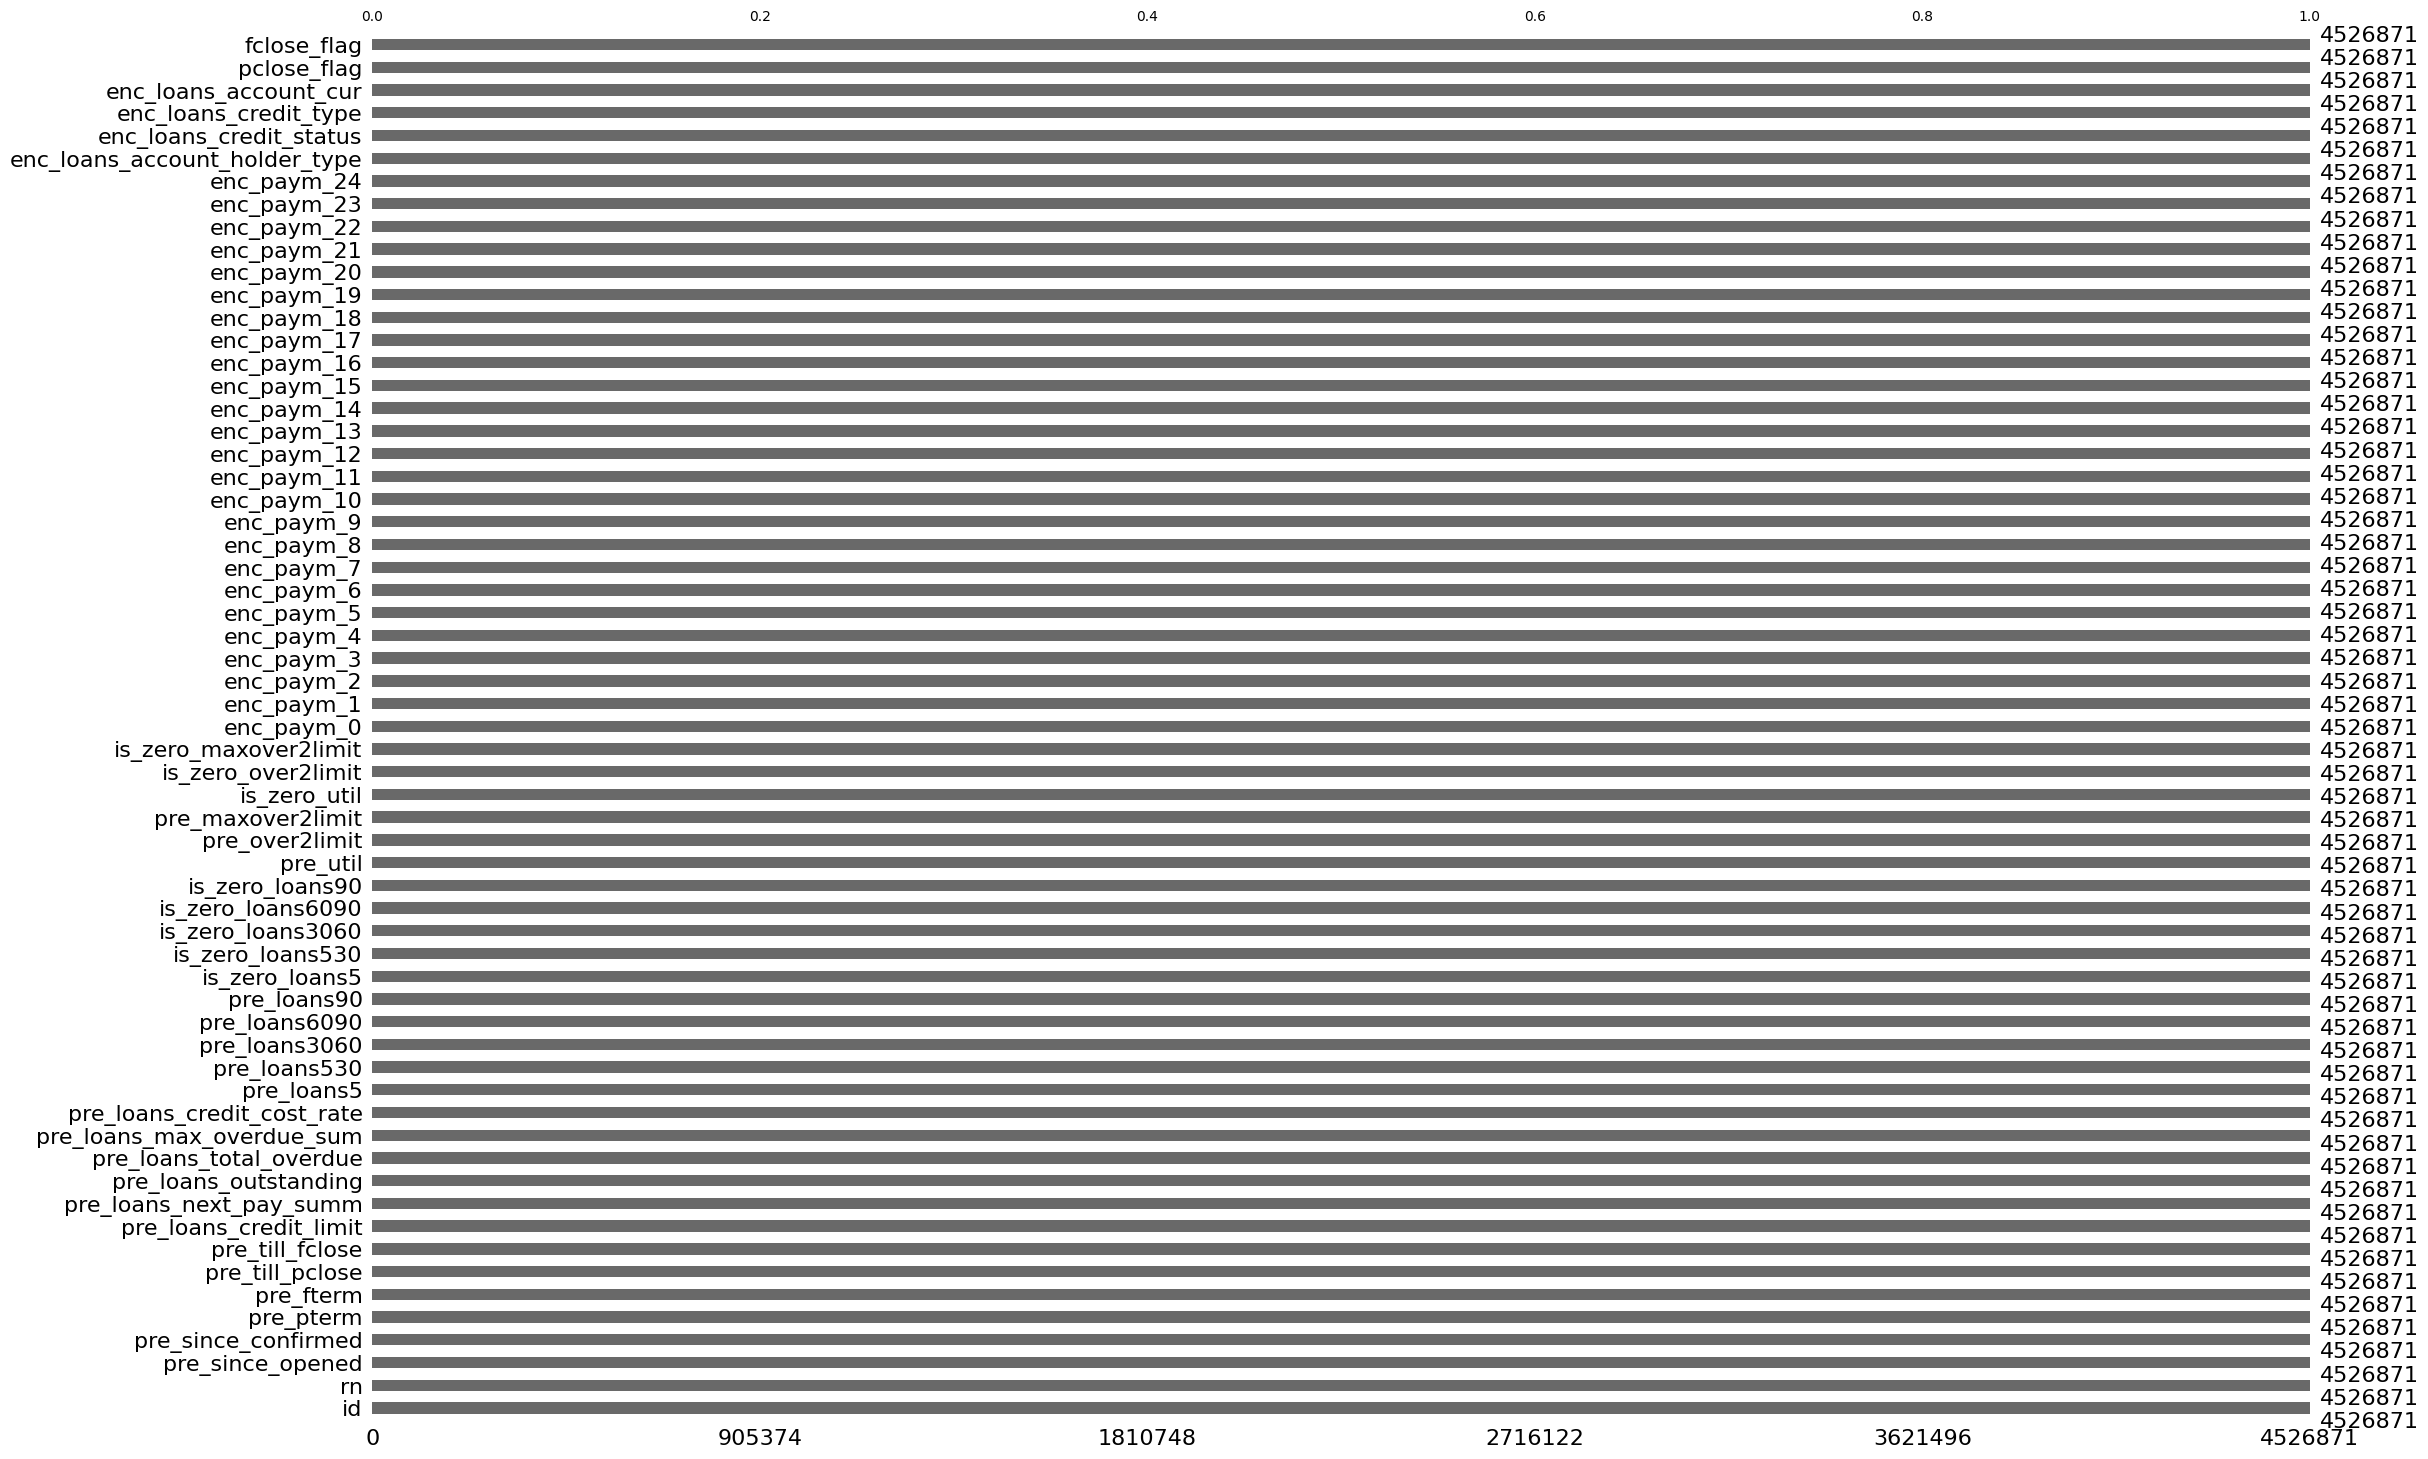

In [ ]:
data = read_parquet_dataset_from_local(path, start_from=10, num_parts_to_read=2, verbose=True)
print_data_info(data)

## что дальше

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']
Reading chunks:

train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_11.pq


'=== data.shape ==='

(2450630, 61)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450630 entries, 0 to 2450629
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  

None

count          mean           std        min   
id                          2450630.0  2.873129e+06  71861.339233  2750000.0  \
rn                          2450630.0  7.536719e+00      5.585190        1.0   
pre_since_opened            2450630.0  9.518576e+00      5.825594        0.0   
pre_since_confirmed         2450630.0  8.823944e+00      4.782442        0.0   
pre_pterm                   2450630.0  8.324652e+00      5.303367        0.0   
pre_fterm                   2450630.0  8.343988e+00      4.525760        0.0   
pre_till_pclose             2450630.0  7.013055e+00      5.161085        0.0   
pre_till_fclose             2450630.0  8.336912e+00      4.243316        0.0   
pre_loans_credit_limit      2450630.0  9.528182e+00      5.848240        0.0   
pre_loans_next_pay_summ     2450630.0  2.359488e+00      1.294435        0.0   
pre_loans_outstanding       2450630.0  2.978873e+00      0.729608        1.0   
pre_loans_total_overdue     2450630.0  0.000000e+00      0.000000        0.0   
pre_loans_max_overdue_sum   2450630.0  2.002484e+00      0.269828        1.0   
pre_loans_credit_cost_rate  2450630.0  4.930588e+00      3.574880        0.0   
pre_loans5                  2450630.0  5.975413e+00      0.385952        0.0   
pre_loans530                2450630.0  1.587862e+01      1.146623        0.0   
pre_loans3060               2450630.0  5.001274e+00      0.075006        1.0   
pre_loans6090               2450630.0  3.999821e+00      0.023023        1.0   
pre_loans90                 2450630.0  8.003930e+00      0.161009        2.0   
is_zero_loans5              2450630.0  9.268147e-01      0.260440        0.0   
is_zero_loans530            2450630.0  8.330650e-01      0.372918        0.0   
is_zero_loans3060           2450630.0  9.602984e-01      0.195257        0.0   
is_zero_loans6090           2450630.0  9.763073e-01      0.152090        0.0   
is_zero_loans90             2450630.0  9.770308e-01      0.149805        0.0   
pre_util                    2450630.0  1.381418e+01      4.361940        0.0   
pre_over2limit              2450630.0  2.234350e+00      0.844323        0.0   
pre_maxover2limit           2450630.0  1.566148e+01      4.000157        0.0   
is_zero_util                2450630.0  6.946553e-01      0.460553        0.0   
is_zero_over2limit          2450630.0  9.214553e-01      0.269027        0.0   
is_zero_maxover2limit       2450630.0  8.520735e-01      0.355027        0.0   
enc_paym_0                  2450630.0  1.469879e-01      0.601968        0.0   
enc_paym_1                  2450630.0  3.410184e-01      0.891713        0.0   
enc_paym_2                  2450630.0  4.705096e-01      1.043204        0.0   
enc_paym_3                  2450630.0  6.020142e-01      1.160143        0.0   
enc_paym_4                  2450630.0  7.267401e-01      1.249038        0.0   
enc_paym_5                  2450630.0  8.556057e-01      1.322742        0.0   
enc_paym_6                  2450630.0  1.004390e+00      1.387805        0.0   
enc_paym_7                  2450630.0  1.163176e+00      1.436649        0.0   
enc_paym_8                  2450630.0  1.274409e+00      1.460081        0.0   
enc_paym_9                  2450630.0  1.382328e+00      1.474312        0.0   
enc_paym_10                 2450630.0  1.501192e+00      1.481227        0.0   
enc_paym_11                 2450630.0  2.637170e+00      1.476569        1.0   
enc_paym_12                 2450630.0  1.761758e+00      1.461632        0.0   
enc_paym_13                 2450630.0  1.895181e+00      1.432213        0.0   
enc_paym_14                 2450630.0  1.961913e+00      1.412849        0.0   
enc_paym_15                 2450630.0  2.015984e+00      1.394666        0.0   
enc_paym_16                 2450630.0  2.065730e+00      1.375814        0.0   
enc_paym_17                 2450630.0  2.112763e+00      1.356191        0.0   
enc_paym_18                 2450630.0  2.162586e+00      1.333110        0.0   
enc_paym_19                 2450

count      mean       std  min  25%  50%   
enc_paym_20                    2450630.0  3.248850  1.287725  1.0  2.0  4.0  \
enc_paym_21                    2450630.0  2.286148  1.265782  0.0  3.0  3.0   
enc_paym_22                    2450630.0  2.321148  1.243942  0.0  3.0  3.0   
enc_paym_23                    2450630.0  2.357841  1.219575  0.0  3.0  3.0   
enc_paym_24                    2450630.0  3.511694  1.098322  1.0  4.0  4.0   
enc_loans_account_holder_type  2450630.0  1.036988  0.316032  0.0  1.0  1.0   
enc_loans_credit_status        2450630.0  2.689747  0.490716  0.0  2.0  3.0   
enc_loans_credit_type          2450630.0  3.638602  1.036298  0.0  3.0  4.0   
enc_loans_account_cur          2450630.0  1.001258  0.042113  0.0  1.0  1.0   
pclose_flag                    2450630.0  0.167358  0.373295  0.0  0.0  0.0   
fclose_flag                    2450630.0  0.217751  0.412718  0.0  0.0  0.0   

                               75%  max  
enc_paym_20                    4.0  4.0  
enc_paym_21                    3.0  3.0  
enc_paym_22                    3.0  3.0  
enc_paym_23                    3.0  3.0  
enc_paym_24                    4.0  4.0  
enc_loans_account_holder_type  1.0  6.0  
enc_loans_credit_status        3.0  6.0  
enc_loans_credit_type          4.0  7.0  
enc_loans_account_cur          1.0  3.0  
pclose_flag                    0.0  1.0  
fclose_flag                    0.0  1.0

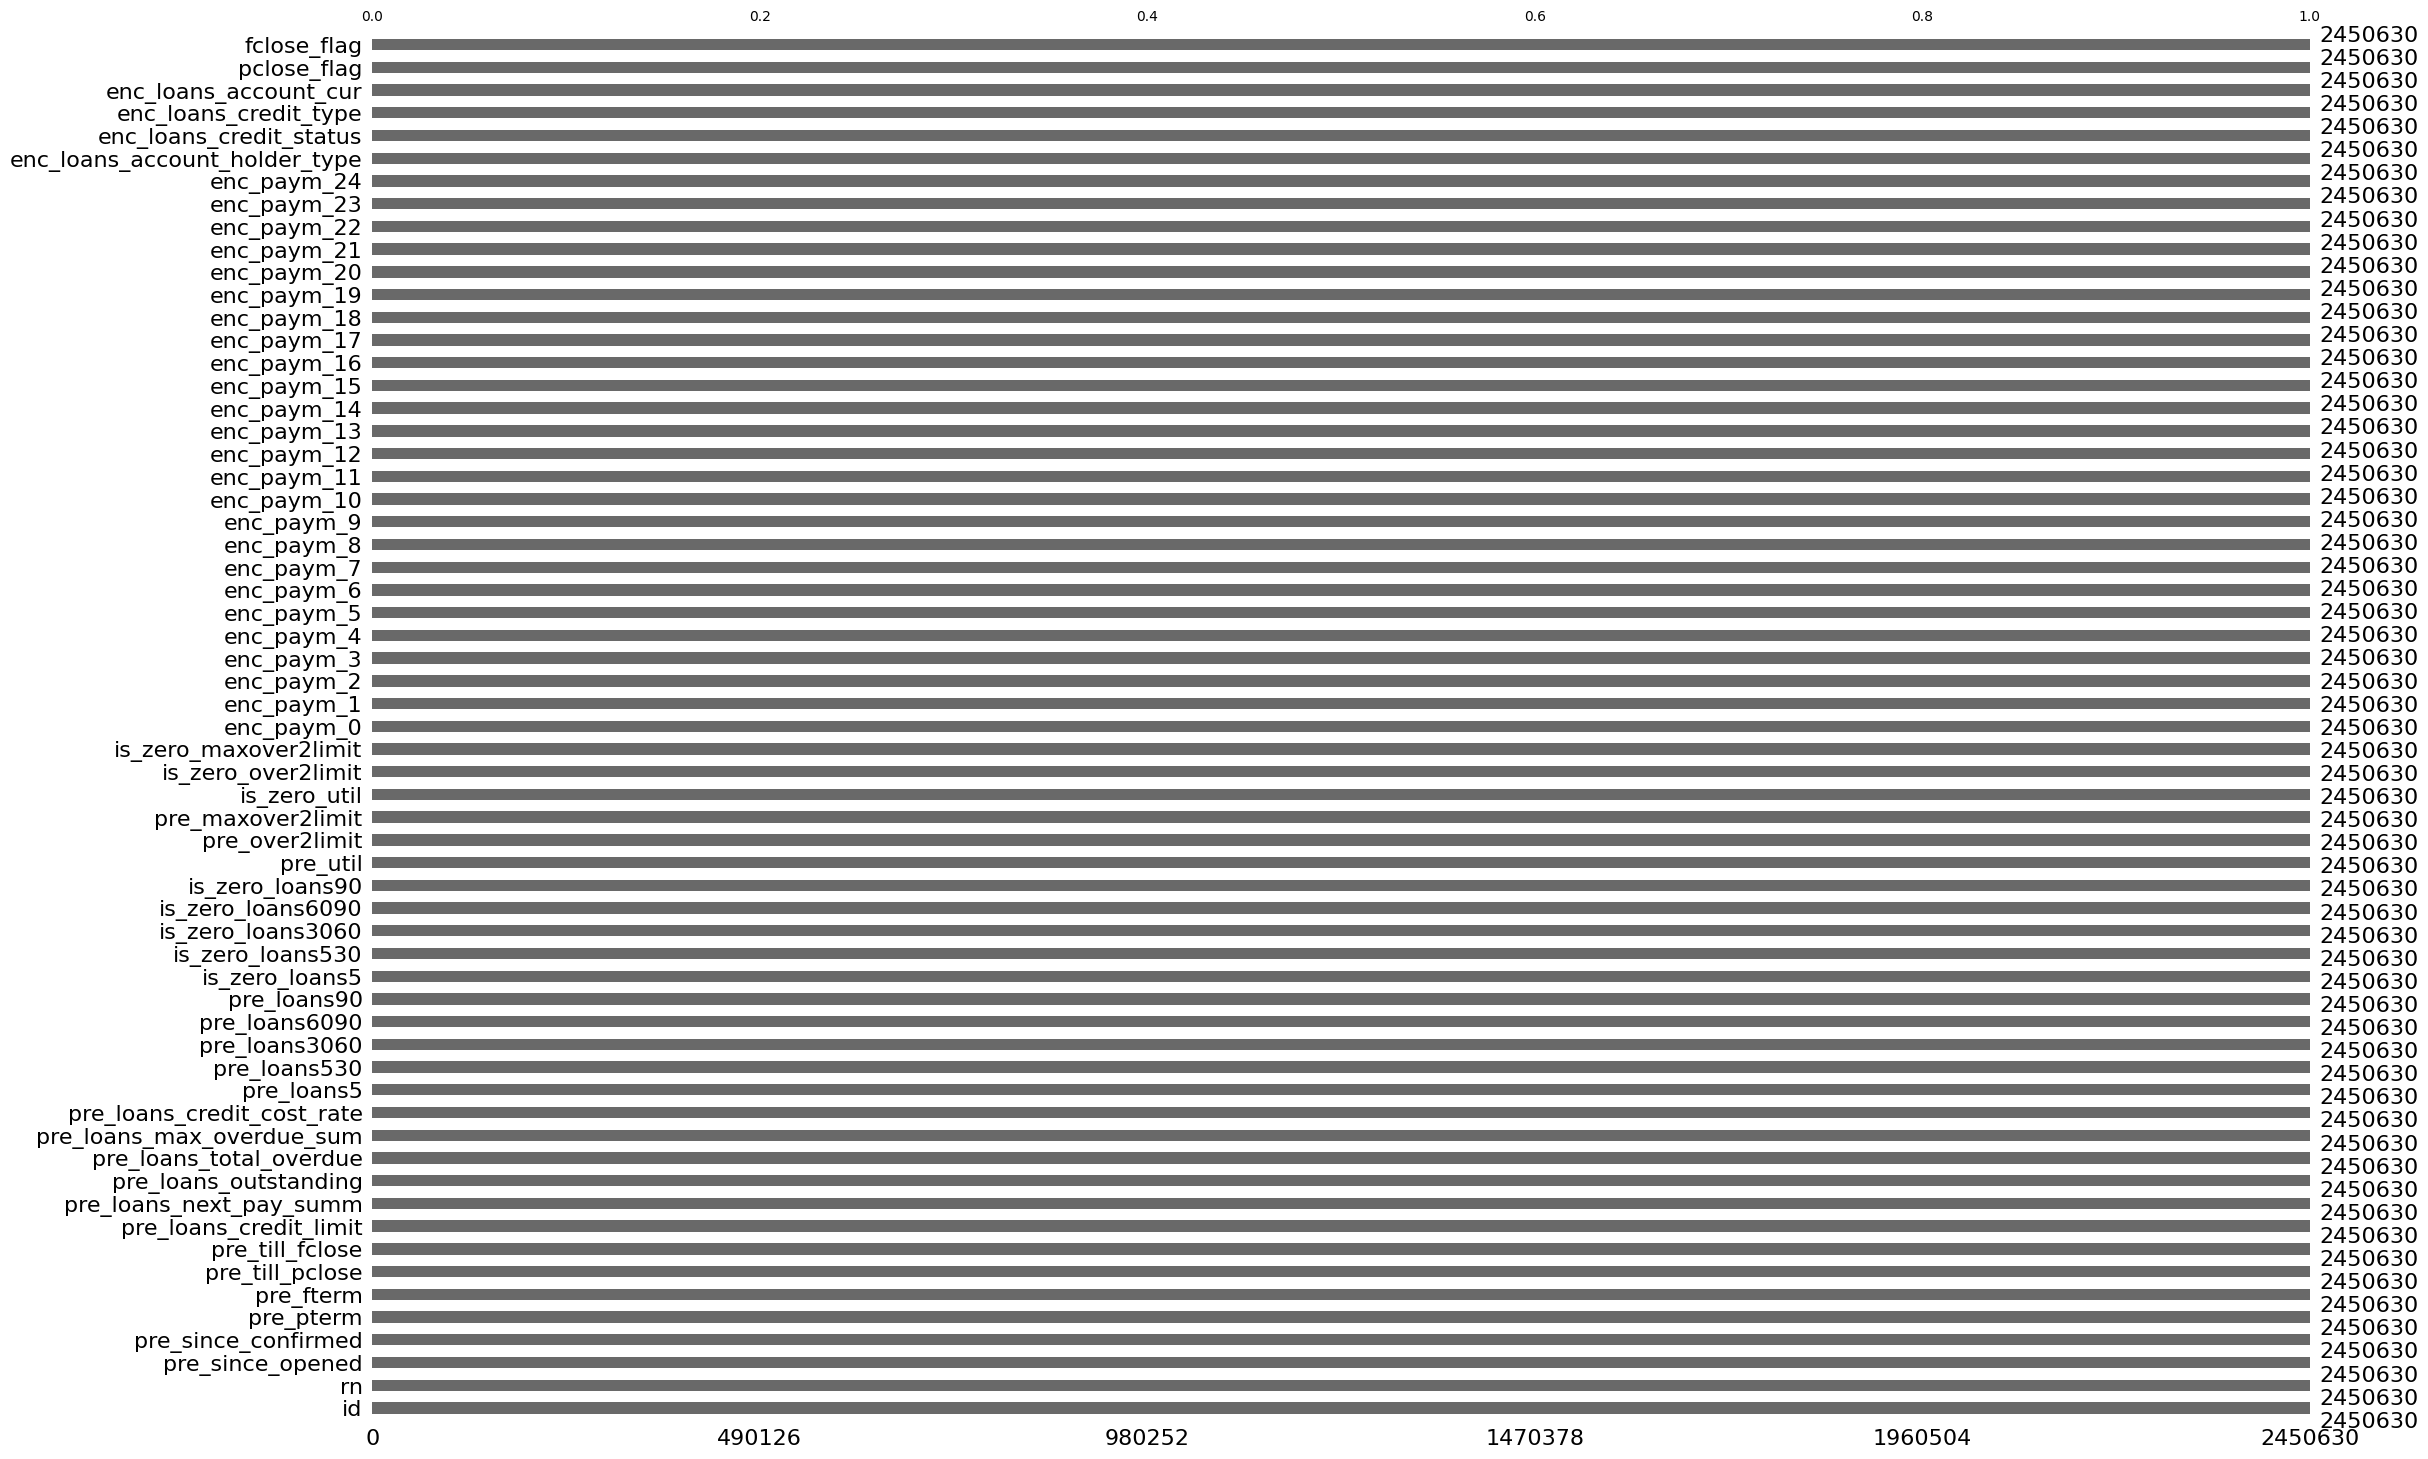

In [ ]:
data = read_parquet_dataset_from_local(path, start_from=3, num_parts_to_read=1, verbose=True)
print_data_info(data)

In [ ]:
columns = list(data.columns)
columns.remove('id')


In [ ]:
for column in columns:
    data[column] = data[column].astype(np.int8)

'=== data.shape ==='

(2450630, 61)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450630 entries, 0 to 2450629
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int8 
 2   pre_since_opened               int8 
 3   pre_since_confirmed            int8 
 4   pre_pterm                      int8 
 5   pre_fterm                      int8 
 6   pre_till_pclose                int8 
 7   pre_till_fclose                int8 
 8   pre_loans_credit_limit         int8 
 9   pre_loans_next_pay_summ        int8 
 10  pre_loans_outstanding          int8 
 11  pre_loans_total_overdue        int8 
 12  pre_loans_max_overdue_sum      int8 
 13  pre_loans_credit_cost_rate     int8 
 14  pre_loans5                     int8 
 15  pre_loans530                   int8 
 16  pre_loans3060                  int8 
 17  pre_loans6090                  int8 
 18  pre_loans90                    int8 
 19  

None

count          mean           std        min   
id                          2450630.0  2.873129e+06  71861.339233  2750000.0  \
rn                          2450630.0  7.536719e+00      5.585190        1.0   
pre_since_opened            2450630.0  9.518576e+00      5.825594        0.0   
pre_since_confirmed         2450630.0  8.823944e+00      4.782442        0.0   
pre_pterm                   2450630.0  8.324652e+00      5.303367        0.0   
pre_fterm                   2450630.0  8.343988e+00      4.525760        0.0   
pre_till_pclose             2450630.0  7.013055e+00      5.161085        0.0   
pre_till_fclose             2450630.0  8.336912e+00      4.243316        0.0   
pre_loans_credit_limit      2450630.0  9.528182e+00      5.848240        0.0   
pre_loans_next_pay_summ     2450630.0  2.359488e+00      1.294435        0.0   
pre_loans_outstanding       2450630.0  2.978873e+00      0.729608        1.0   
pre_loans_total_overdue     2450630.0  0.000000e+00      0.000000        0.0   
pre_loans_max_overdue_sum   2450630.0  2.002484e+00      0.269828        1.0   
pre_loans_credit_cost_rate  2450630.0  4.930588e+00      3.574880        0.0   
pre_loans5                  2450630.0  5.975413e+00      0.385952        0.0   
pre_loans530                2450630.0  1.587862e+01      1.146623        0.0   
pre_loans3060               2450630.0  5.001274e+00      0.075006        1.0   
pre_loans6090               2450630.0  3.999821e+00      0.023023        1.0   
pre_loans90                 2450630.0  8.003930e+00      0.161009        2.0   
is_zero_loans5              2450630.0  9.268147e-01      0.260440        0.0   
is_zero_loans530            2450630.0  8.330650e-01      0.372918        0.0   
is_zero_loans3060           2450630.0  9.602984e-01      0.195257        0.0   
is_zero_loans6090           2450630.0  9.763073e-01      0.152090        0.0   
is_zero_loans90             2450630.0  9.770308e-01      0.149805        0.0   
pre_util                    2450630.0  1.381418e+01      4.361940        0.0   
pre_over2limit              2450630.0  2.234350e+00      0.844323        0.0   
pre_maxover2limit           2450630.0  1.566148e+01      4.000157        0.0   
is_zero_util                2450630.0  6.946553e-01      0.460553        0.0   
is_zero_over2limit          2450630.0  9.214553e-01      0.269027        0.0   
is_zero_maxover2limit       2450630.0  8.520735e-01      0.355027        0.0   
enc_paym_0                  2450630.0  1.469879e-01      0.601968        0.0   
enc_paym_1                  2450630.0  3.410184e-01      0.891713        0.0   
enc_paym_2                  2450630.0  4.705096e-01      1.043204        0.0   
enc_paym_3                  2450630.0  6.020142e-01      1.160143        0.0   
enc_paym_4                  2450630.0  7.267401e-01      1.249038        0.0   
enc_paym_5                  2450630.0  8.556057e-01      1.322742        0.0   
enc_paym_6                  2450630.0  1.004390e+00      1.387805        0.0   
enc_paym_7                  2450630.0  1.163176e+00      1.436649        0.0   
enc_paym_8                  2450630.0  1.274409e+00      1.460081        0.0   
enc_paym_9                  2450630.0  1.382328e+00      1.474312        0.0   
enc_paym_10                 2450630.0  1.501192e+00      1.481227        0.0   
enc_paym_11                 2450630.0  2.637170e+00      1.476569        1.0   
enc_paym_12                 2450630.0  1.761758e+00      1.461632        0.0   
enc_paym_13                 2450630.0  1.895181e+00      1.432213        0.0   
enc_paym_14                 2450630.0  1.961913e+00      1.412849        0.0   
enc_paym_15                 2450630.0  2.015984e+00      1.394666        0.0   
enc_paym_16                 2450630.0  2.065730e+00      1.375814        0.0   
enc_paym_17                 2450630.0  2.112763e+00      1.356191        0.0   
enc_paym_18                 2450630.0  2.162586e+00      1.333110        0.0   
enc_paym_19                 2450

count      mean       std  min  25%  50%   
enc_paym_20                    2450630.0  3.248850  1.287725  1.0  2.0  4.0  \
enc_paym_21                    2450630.0  2.286148  1.265782  0.0  3.0  3.0   
enc_paym_22                    2450630.0  2.321148  1.243942  0.0  3.0  3.0   
enc_paym_23                    2450630.0  2.357841  1.219575  0.0  3.0  3.0   
enc_paym_24                    2450630.0  3.511694  1.098322  1.0  4.0  4.0   
enc_loans_account_holder_type  2450630.0  1.036988  0.316032  0.0  1.0  1.0   
enc_loans_credit_status        2450630.0  2.689747  0.490716  0.0  2.0  3.0   
enc_loans_credit_type          2450630.0  3.638602  1.036298  0.0  3.0  4.0   
enc_loans_account_cur          2450630.0  1.001258  0.042113  0.0  1.0  1.0   
pclose_flag                    2450630.0  0.167358  0.373295  0.0  0.0  0.0   
fclose_flag                    2450630.0  0.217751  0.412718  0.0  0.0  0.0   

                               75%  max  
enc_paym_20                    4.0  4.0  
enc_paym_21                    3.0  3.0  
enc_paym_22                    3.0  3.0  
enc_paym_23                    3.0  3.0  
enc_paym_24                    4.0  4.0  
enc_loans_account_holder_type  1.0  6.0  
enc_loans_credit_status        3.0  6.0  
enc_loans_credit_type          4.0  7.0  
enc_loans_account_cur          1.0  3.0  
pclose_flag                    0.0  1.0  
fclose_flag                    0.0  1.0

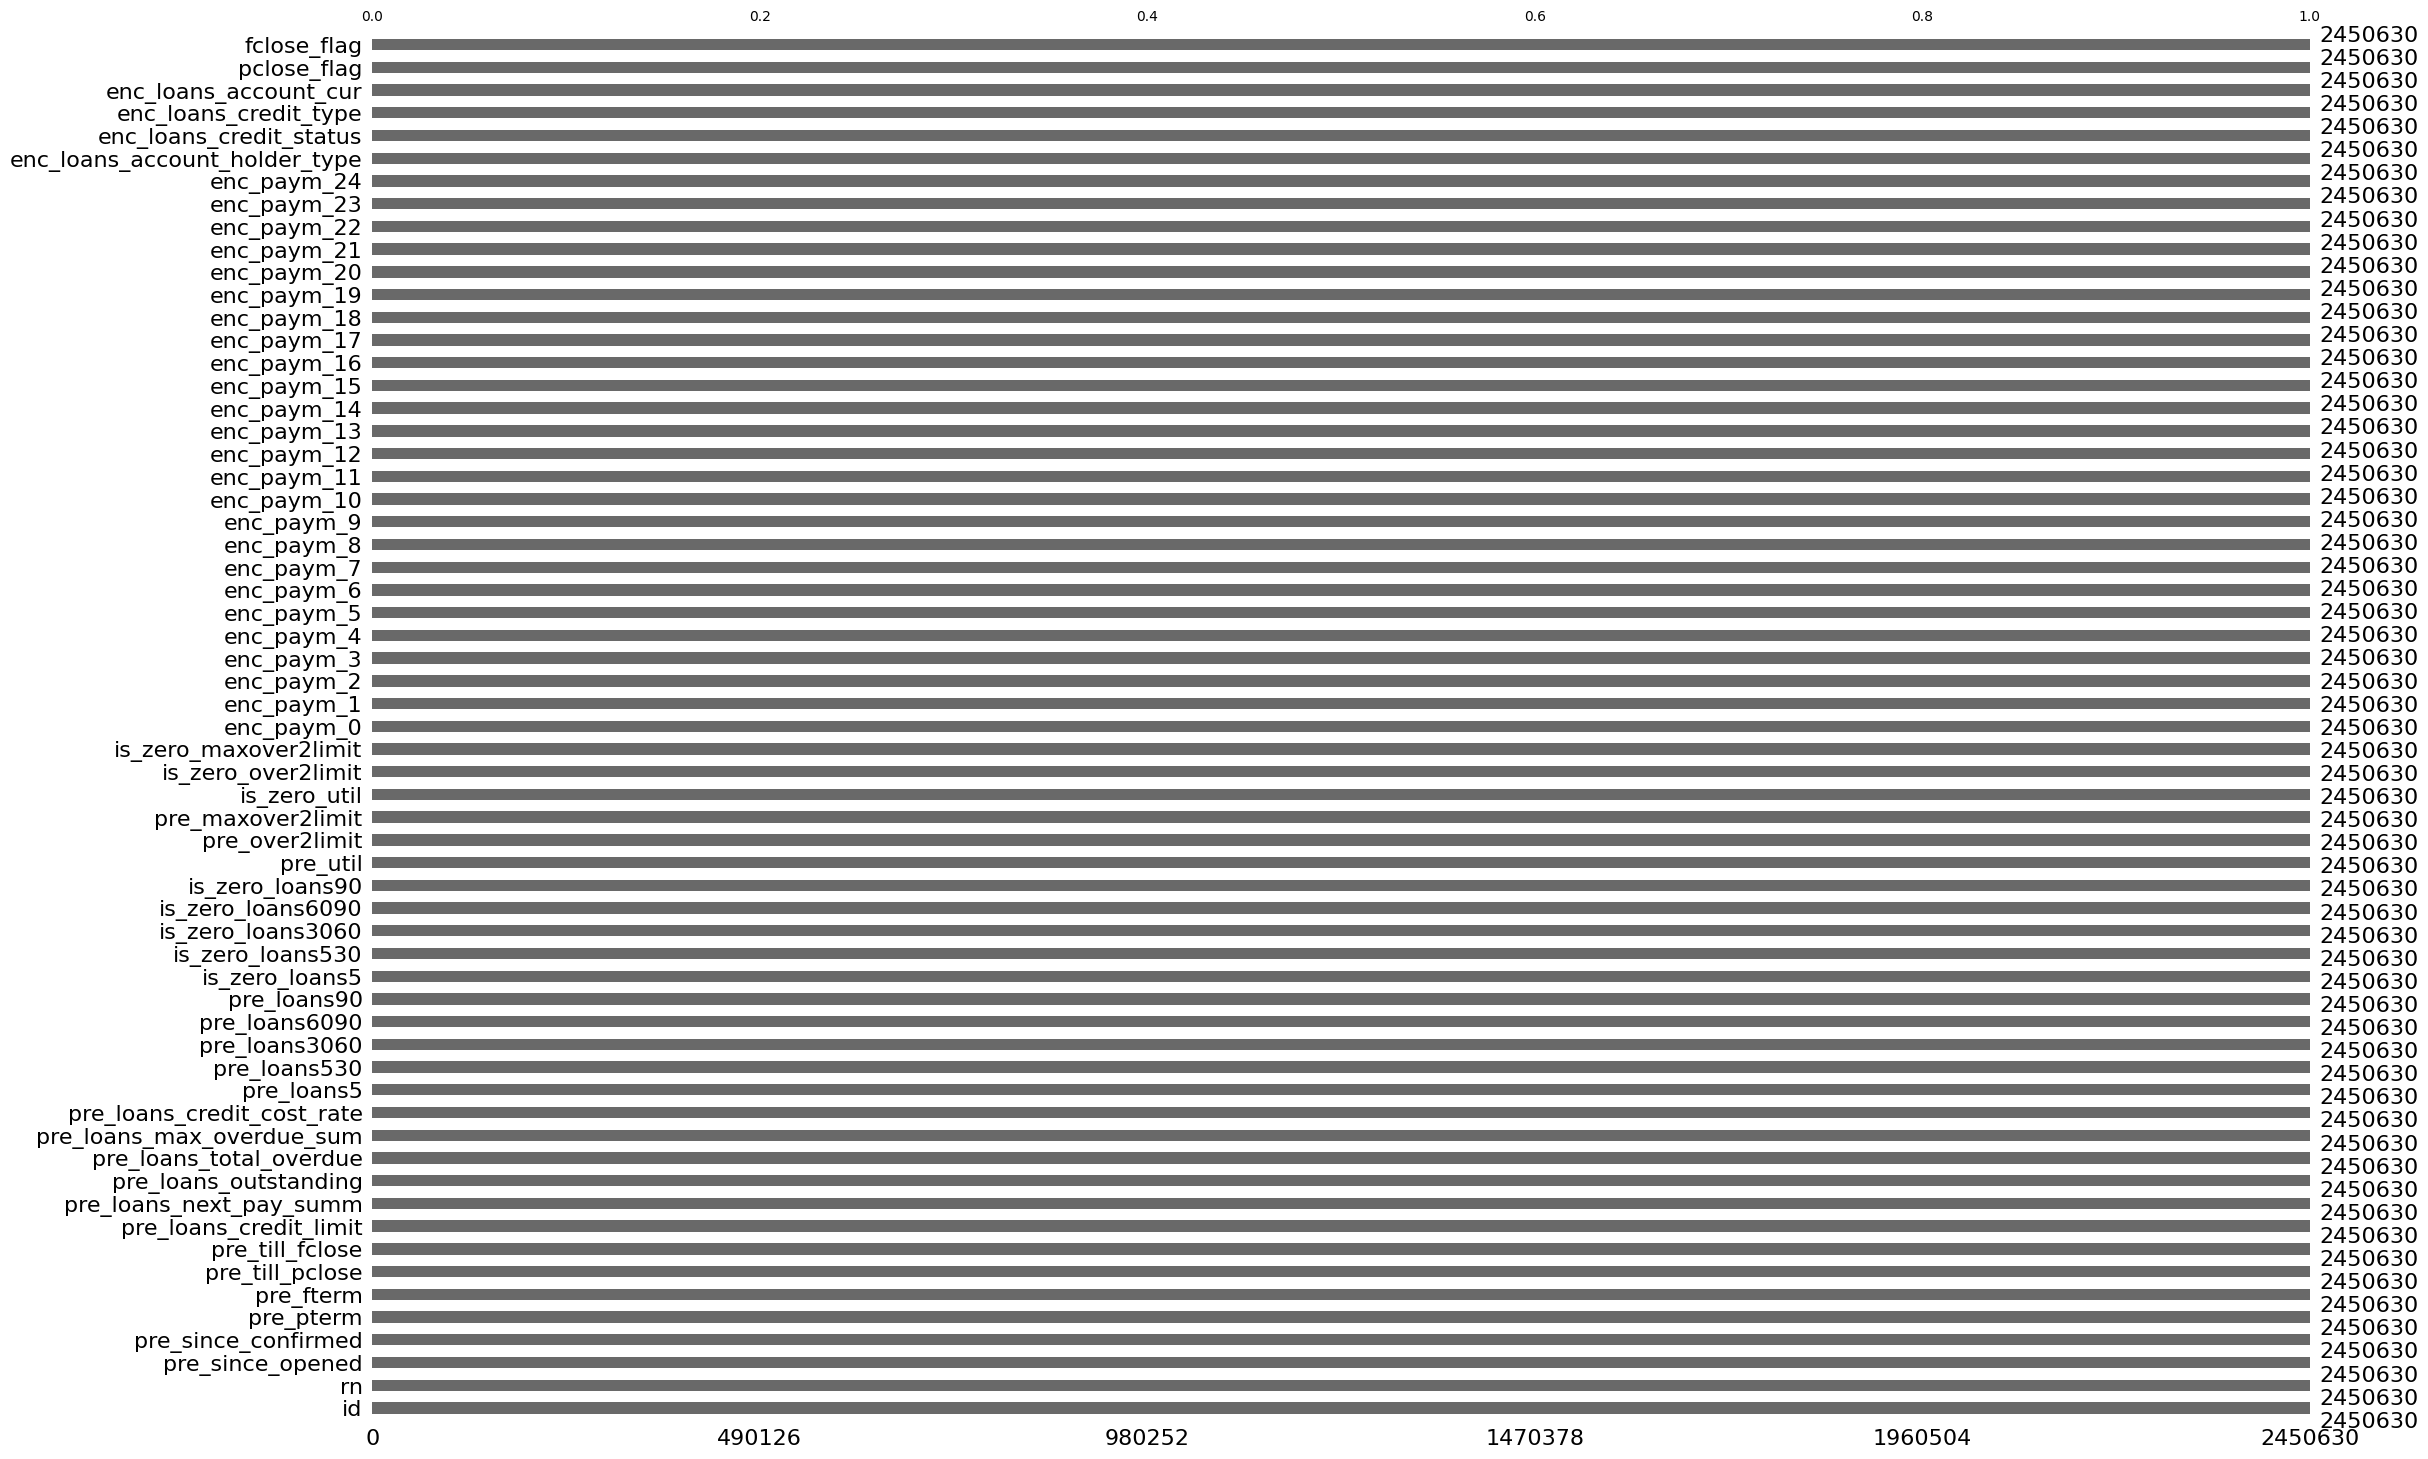

In [ ]:
print_data_info(data)

<Axes: >

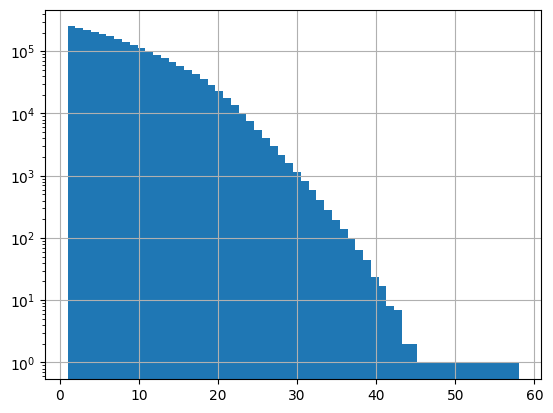

In [ ]:
data.rn.hist(bins=58, log=True)

In [ ]:
data

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm   
0        2750000   1                 2                    2          2  \
1        2750000   2                 1                    2         14   
2        2750000   3                 9                    2          4   
3        2750000   4                 9                    2         11   
4        2750000   5                 9                    2          6   
...          ...  ..               ...                  ...        ...   
2450625  2999999   8                 6                    5         14   
2450626  2999999   9                 5                    3          2   
2450627  2999999  10                 3                   16         11   
2450628  2999999  11                 3                    6          4   
2450629  2999999  12                 2                    2          2   

         pre_fterm  pre_till_pclose  pre_till_fclose  pre_loans_credit_limit   
0               14               12               11                       3  \
1                7               10                8                      10   
2                8                1               11                      14   
3               16               14                8                       9   
4                1                0                4                       4   
...            ...              ...              ...                     ...   
2450625         13                1               15                      16   
2450626         10               15               14                      17   
2450627         13               14                8                      15   
2450628          8                1               11                       0   
2450629         14               12               11                      10   

         pre_loans_next_pay_summ  ...  enc_paym_21  enc_paym_22  enc_paym_23   
0                              6  ...            3            3            3  \
1                              1  ...            3            3            3   
2                              2  ...            3            3            3   
3                              3  ...            3            3            3   
4                              2  ...            3            3            3   
...                          ...  ...          ...          ...          ...   
2450625                        2  ...            0            0            0   
2450626                        2  ...            0            0            0   
2450627                        5  ...            0            0            3   
2450628                        5  ...            3            3            3   
2450629                        1  ...            3            3            3   

         enc_paym_24  enc_loans_account_holder_type  enc_loans_credit_status   
0                  4                              1                        2  \
1                  4                              1                        2   
2                  4                              1                        2   
3                  4                              1                        2   
4                  4                              1                        2   
...              ...                            ...                      ...   
2450625            1                              1                        3   
2450626            4                              1                        3   
2450627            4                              1                        2   
2450628            4                              1                        2   
2450629            4                              1                        2   

         enc_loans_credit_type  enc_loans_account_cur  pclose_flag   
0                            4                      1            0  \
1                            3                      1            0   
2                            3  

In [ ]:
data.set_index(['id', 'rn'], inplace=False)

pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm   
id      rn                                                                
2750000 1                  2                    2          2         14  \
        2                  1                    2         14          7   
        3                  9                    2          4          8   
        4                  9                    2         11         16   
        5                  9                    2          6          1   
...                      ...                  ...        ...        ...   
2999999 8                  6                    5         14         13   
        9                  5                    3          2         10   
        10                 3                   16         11         13   
        11                 3                    6          4          8   
        12                 2                    2          2         14   

            pre_till_pclose  pre_till_fclose  pre_loans_credit_limit   
id      rn                                                             
2750000 1                12               11                       3  \
        2                10                8                      10   
        3                 1               11                      14   
        4                14                8                       9   
        5                 0                4                       4   
...                     ...              ...                     ...   
2999999 8                 1               15                      16   
        9                15               14                      17   
        10               14                8                      15   
        11                1               11                       0   
        12               12               11                      10   

            pre_loans_next_pay_summ  pre_loans_outstanding   
id      rn                                                   
2750000 1                         6                      3  \
        2                         1                      2   
        3                         2                      3   
        4                         3                      5   
        5                         2                      3   
...                             ...                    ...   
2999999 8                         2                      3   
        9                         2                      3   
        10                        5                      1   
        11                        5                      1   
        12                        1                      4   

            pre_loans_total_overdue  ...  enc_paym_21  enc_paym_22   
id      rn                           ...                             
2750000 1                         0  ...            3            3  \
        2                         0  ...            3            3   
        3                         0  ...            3            3   
        4                         0  ...            3            3   
        5                         0  ...            3            3   
...                             ...  ...          ...          ...   
2999999 8                         0  ...            0            0   
        9                         0  ...            0            0   
        10                        0  ...            0            0   
        11                        0  ...            3            3   
        12                        0  ...            3            3   

            enc_paym_23  enc_paym_24  enc_loans_account_holder_type   
id      rn                                                            
2750000 1             3            4                              1  \
        2             3            4                              1   
        3             3            4                              1   
        4             3   

In [ ]:
df.stack().unstack([-2,-1]).rename_axis((None, None), axis=1)

In [ ]:
data.set_index(['id', 'rn'], inplace=False).stack().unstack([-2,-1]).rename_axis((None, None), axis=1)

1                                            
        pre_since_opened pre_since_confirmed pre_pterm pre_fterm   
id                                                                 
2750000              2.0                 2.0       2.0      14.0  \
2750001             15.0                17.0       7.0       2.0   
2750002              1.0                16.0       2.0       8.0   
2750003             10.0                 4.0       6.0       8.0   
2750004              0.0                17.0       9.0      12.0   
...                  ...                 ...       ...       ...   
2999995             15.0                 4.0      17.0      16.0   
2999996             16.0                 8.0      16.0      15.0   
2999997              4.0                 8.0       7.0       6.0   
2999998              4.0                11.0       4.0      15.0   
2999999             16.0                17.0       7.0       2.0   

                                                                 
        pre_till_pclose pre_till_fclose pre_loans_credit_limit   
id                                                               
2750000            12.0            11.0                    3.0  \
2750001             9.0             1.0                    5.0   
2750002            12.0            11.0                    7.0   
2750003             0.0            11.0                   10.0   
2750004            13.0             5.0                    3.0   
...                 ...             ...                    ...   
2999995            13.0             3.0                   14.0   
2999996             4.0             9.0                   13.0   
2999997             5.0             7.0                   17.0   
2999998             1.0            12.0                    4.0   
2999999             4.0             9.0                    5.0   

                                                                                
        pre_loans_next_pay_summ pre_loans_outstanding pre_loans_total_overdue   
id                                                                              
2750000                     6.0                   3.0                     0.0  \
2750001                     2.0                   3.0                     0.0   
2750002                     3.0                   2.0                     0.0   
2750003                     2.0                   3.0                     0.0   
2750004                     2.0                   3.0                     0.0   
...                         ...                   ...                     ...   
2999995                     2.0                   3.0                     0.0   
2999996                     2.0                   3.0                     0.0   
2999997                     2.0                   3.0                     0.0   
2999998                     2.0                   3.0                     0.0   
2999999                     2.0                   3.0                     0.0   

         ...          58                                       
         ... enc_paym_21 enc_paym_22 enc_paym_23 enc_paym_24   
id       ...                                                   
2750000  ...         NaN         NaN         NaN         NaN  \
2750001  ...         NaN         NaN         NaN         NaN   
2750002  ...         NaN         NaN         NaN         NaN   
2750003  ...         NaN         NaN         NaN         NaN   
2750004  ...         NaN         NaN         NaN         NaN   
...      ...         ...         ...         ...         ...   
2999995  ...         NaN         NaN         NaN         NaN   
2999996  ...         NaN         NaN         NaN         NaN   
2999997  ...         NaN         NaN         NaN         NaN   
2999998  ...         NaN         NaN         NaN         NaN   
2999999  ...         NaN         NaN         NaN         NaN   

                                                                
        enc_loans_account_holder_type enc_loans

## возвращение

In [10]:
data = prepare_transactions_dataset(path_to_dataset=path,
                                    num_parts_to_preprocess_at_once = 1,
                                    num_parts_total=12,
                                    save_to_path=None,
                                    verbose=True)

<ipython-input-9-7018661c4ab0>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),


Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

['/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_0.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_1.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_10.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_11.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_2.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_3.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_4.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_5.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_6.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_7.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_8.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_9.pq']
Reading chunks:

/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_0.pq


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_0.pq
['/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_0.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_1.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_10.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_11.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_2.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_3.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_4.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_5.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_6.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_7.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_8.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_9.pq']
Reading chunks

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_1.pq
['/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_0.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_1.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_10.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_11.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_2.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_3.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_4.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_5.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_6.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_7.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_8.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_9.pq']
Reading chunks

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_10.pq
['/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_0.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_1.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_10.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_11.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_2.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_3.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_4.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_5.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_6.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_7.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_8.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_9.pq']
Reading chunk

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_11.pq
['/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_0.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_1.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_10.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_11.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_2.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_3.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_4.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_5.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_6.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_7.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_8.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_9.pq']
Reading chunk

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_2.pq
['/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_0.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_1.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_10.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_11.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_2.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_3.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_4.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_5.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_6.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_7.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_8.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_9.pq']
Reading chunks

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_3.pq
['/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_0.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_1.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_10.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_11.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_2.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_3.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_4.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_5.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_6.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_7.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_8.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_9.pq']
Reading chunks

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_4.pq
['/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_0.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_1.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_10.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_11.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_2.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_3.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_4.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_5.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_6.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_7.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_8.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_9.pq']
Reading chunks

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_5.pq
['/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_0.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_1.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_10.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_11.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_2.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_3.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_4.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_5.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_6.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_7.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_8.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_9.pq']
Reading chunks

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_6.pq
['/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_0.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_1.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_10.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_11.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_2.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_3.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_4.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_5.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_6.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_7.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_8.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_9.pq']
Reading chunks

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_7.pq
['/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_0.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_1.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_10.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_11.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_2.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_3.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_4.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_5.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_6.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_7.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_8.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_9.pq']
Reading chunks

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_8.pq
['/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_0.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_1.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_10.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_11.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_2.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_3.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_4.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_5.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_6.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_7.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_8.pq', '/content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_9.pq']
Reading chunks

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path /content/drive/MyDrive/Skillbox/DS-jun-final/train_data/train_data_9.pq


In [ ]:
data.columns

Index(['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 

In [11]:
data['rn'].max()

58

<Axes: >

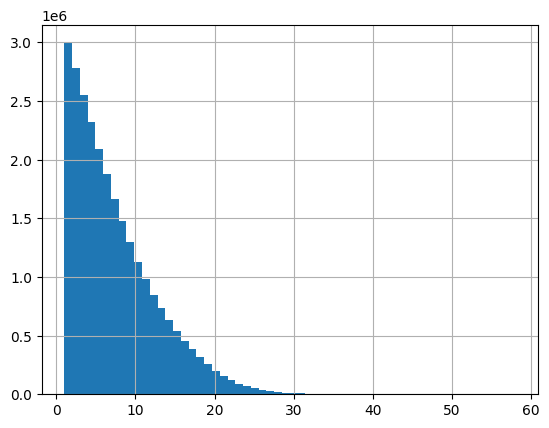

In [12]:
data['rn'].hist(bins=58)

In [13]:
q3 = np.percentile(data['rn'], 75)
q3

10.0

In [14]:
q1 = np.percentile(data['rn'], 25)
q1

3.0

In [15]:
max_rn_count = int(q3 + 1.5*(q3 - q1))
max_rn_count

20

In [16]:
df_for_rn = data.groupby(by='id').agg({'rn': 'max'})

In [17]:
df_for_rn

rn
id         
0        10
1        14
2         3
3        15
4         1
...      ..
2999995  11
2999996  13
2999997  10
2999998   5
2999999  12

[3000000 rows x 1 columns]

In [18]:
max_rn = data['id'].apply(lambda x: df_for_rn.values[x][0])

In [19]:
max_rn = max_rn.astype(np.int8)
max_rn

0          10
1          10
2          10
3          10
4          10
           ..
2284251    15
2284252    15
2284253    15
2284254    15
2284255    15
Name: id, Length: 26162717, dtype: int8

In [7]:
data

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  \
0               0   9                18                    9          2   
1               0   8                18                    9         14   
2               0   7                18                    9          4   
3               0   6                 4                    1          9   
4               0   5                 5                   12         15   
...           ...  ..               ...                  ...        ...   
26162712  2499999   4                 3                    9          4   
26162713  2499999   3                 3                    9          1   
26162714  2499999   2                 2                    9          4   
26162715  2499999   1                 2                    9          4   
26162716  2499999   0                 7                    9         17   

          pre_fterm  pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0                 3               16               10                      11   
1                14               12               12                       0   
2                 8                1               11                      11   
3                12               16                7                      12   
4                 2               11               12                      10   
...             ...              ...              ...                     ...   
26162712          3                1               12                       6   
26162713         15               12                6                       9   
26162714          8                1               11                       7   
26162715          9                1               15                      16   
26162716         14                8                8                       0   

          pre_loans_next_pay_summ  ...  enc_paym_23  enc_paym_24  \
0                               3  ...            3            4   
1                               3  ...            0            4   
2                               0  ...            0            4   
3                               2  ...            3            4   
4                               2  ...            3            4   
...                           ...  ...          ...          ...   
26162712                        2  ...            3            4   
26162713                        3  ...            3            4   
26162714                        3  ...            3            4   
26162715                        2  ...            3            4   
26162716                        0  ...            3            4   

          enc_loans_account_holder_type  enc_loans_credit_status  \
0                                     1                        3   
1                                     1                        3   
2                                     1                        2   
3                                     1                        3   
4                                     1                        3   
...                                 ...                      ...   
26162712                              1                        3   
26162713                              1                        3   
26162714                              1                        2   
26162715                              1                        3   
26162716                              1                        2   

          enc_loans_credit_type  enc_loans_account_cur  pclose_flag  \
0                             4                      1            0   
1                             4                      1            0   
2                             3                      1            1   
3                             1                      1            0   
4                             4                      1            0   
...                         ...                    ...          ...   
26162712  

In [20]:
data['max_rn'] = max_rn

In [21]:
data['rn'] = max_rn - data['rn']

In [22]:
data = data[data['rn'] < max_rn_count]

In [23]:
data.shape

(25537912, 62)

In [24]:
data.to_pickle(path='/content/drive/MyDrive/Skillbox/DS-jun-final/last_data.pkl')

## Моделирование 2

In [42]:
data = pd.read_pickle('last_data2.pkl')

In [15]:
data.columns

Index(['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 

In [25]:
# data = data[data['rn'] == 0]

In [26]:
# data.to_pickle(path='/content/drive/MyDrive/Skillbox/DS-jun-final/zero.pkl')

In [4]:
# data = pd.read_pickle('/content/drive/MyDrive/Skillbox/DS-jun-final/zero.pkl')

In [14]:
# data.columns

In [43]:
std_scaler = StandardScaler()
std_scaler.fit(data[['max_rn']])
data['max_rn'] = std_scaler.transform(data[['max_rn']])

In [44]:
%%time
ohe = OneHotEncoder(sparse_output=True, drop='first', handle_unknown='ignore', dtype=np.int8)
cat_cols = data.drop(columns=['id', 'rn', 'max_rn']).columns
ohe.fit(data[cat_cols])
ohe_data = ohe.transform(data[cat_cols])


CPU times: total: 4min 14s
Wall time: 11min 31s


In [45]:
ohe.get_params()

{'categories': 'auto',
 'drop': 'first',
 'dtype': numpy.int8,
 'feature_name_combiner': 'concat',
 'handle_unknown': 'ignore',
 'max_categories': None,
 'min_frequency': None,
 'sparse': 'deprecated',
 'sparse_output': True}

In [25]:
# nsp_data = ohe_data.toarray()

In [26]:
# nsp_data.shape

(3000000, 346)

In [46]:
data = data.drop(columns=cat_cols)



In [47]:
%%time
data[ohe.get_feature_names_out()] = ohe_data.toarray()
print('done')

<timed exec>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

done
CPU times: total: 3min 3s
Wall time: 19min 19s


In [48]:
%%time
# data.to_pickle(path='/content/drive/MyDrive/Skillbox/DS-jun-final/sparse2.pkl')
data.to_pickle(path='sparse_v-2.pkl')

CPU times: total: 13.2 s
Wall time: 6min 16s


In [ ]:
тут

In [6]:
data = pd.read_pickle('sparse_v2.pkl')

In [7]:
df_0 = data[data['rn'] == 0]
df_1 = data[data['rn'] == 1]
data = data[data['rn'] > 1]

In [10]:
df_0.columns

Index(['id', 'pre_since_opened_1', 'pre_since_opened_2', 'pre_since_opened_3',
       'pre_since_opened_4', 'pre_since_opened_5', 'pre_since_opened_6',
       'pre_since_opened_7', 'pre_since_opened_8', 'pre_since_opened_9',
       ...
       'enc_loans_credit_type_4', 'enc_loans_credit_type_5',
       'enc_loans_credit_type_6', 'enc_loans_credit_type_7',
       'enc_loans_account_cur_1', 'enc_loans_account_cur_2',
       'enc_loans_account_cur_3', 'pclose_flag_1', 'fclose_flag_1', 'flag_1'],
      dtype='object', length=345)

In [13]:
df_1.columns

Index(['id', 'pre_since_opened_1', 'pre_since_opened_2', 'pre_since_opened_3',
       'pre_since_opened_4', 'pre_since_opened_5', 'pre_since_opened_6',
       'pre_since_opened_7', 'pre_since_opened_8', 'pre_since_opened_9',
       ...
       'enc_loans_credit_type_4', 'enc_loans_credit_type_5',
       'enc_loans_credit_type_6', 'enc_loans_credit_type_7',
       'enc_loans_account_cur_1', 'enc_loans_account_cur_2',
       'enc_loans_account_cur_3', 'pclose_flag_1', 'fclose_flag_1', 'flag_1'],
      dtype='object', length=345)

In [15]:
data.columns

Index(['id', 'rn', 'max_rn', 'pre_since_opened_1', 'pre_since_opened_2',
       'pre_since_opened_3', 'pre_since_opened_4', 'pre_since_opened_5',
       'pre_since_opened_6', 'pre_since_opened_7',
       ...
       'enc_loans_credit_type_4', 'enc_loans_credit_type_5',
       'enc_loans_credit_type_6', 'enc_loans_credit_type_7',
       'enc_loans_account_cur_1', 'enc_loans_account_cur_2',
       'enc_loans_account_cur_3', 'pclose_flag_1', 'fclose_flag_1', 'flag_1'],
      dtype='object', length=347)

In [8]:
df_0.drop(columns=['rn', 'max_rn'], inplace=True)

In [12]:
df_0.drop(columns=['flag_1'], inplace=True)

In [9]:
df_1.drop(columns=['rn', 'max_rn'], inplace=True)

In [14]:
df_1.drop(columns=['flag_1'], inplace=True)

In [18]:
cols = data.columns.tolist()
cols.remove('id')
cols.remove('rn')
cols.remove('max_rn')
cols.remove('flag_1')

In [19]:
data.shape

(19758457, 347)

In [20]:
# agg_dict = dict((i, ['first', 'sum']) for i in ohe.get_feature_names_out())
agg_dict = dict((i, 'sum') for i in cols)
agg_dict

{'pre_since_opened_1': 'sum',
 'pre_since_opened_2': 'sum',
 'pre_since_opened_3': 'sum',
 'pre_since_opened_4': 'sum',
 'pre_since_opened_5': 'sum',
 'pre_since_opened_6': 'sum',
 'pre_since_opened_7': 'sum',
 'pre_since_opened_8': 'sum',
 'pre_since_opened_9': 'sum',
 'pre_since_opened_10': 'sum',
 'pre_since_opened_11': 'sum',
 'pre_since_opened_12': 'sum',
 'pre_since_opened_13': 'sum',
 'pre_since_opened_14': 'sum',
 'pre_since_opened_15': 'sum',
 'pre_since_opened_16': 'sum',
 'pre_since_opened_17': 'sum',
 'pre_since_opened_18': 'sum',
 'pre_since_opened_19': 'sum',
 'pre_since_confirmed_1': 'sum',
 'pre_since_confirmed_2': 'sum',
 'pre_since_confirmed_3': 'sum',
 'pre_since_confirmed_4': 'sum',
 'pre_since_confirmed_5': 'sum',
 'pre_since_confirmed_6': 'sum',
 'pre_since_confirmed_7': 'sum',
 'pre_since_confirmed_8': 'sum',
 'pre_since_confirmed_9': 'sum',
 'pre_since_confirmed_10': 'sum',
 'pre_since_confirmed_11': 'sum',
 'pre_since_confirmed_12': 'sum',
 'pre_since_confirmed

In [27]:
# agg_dict | {'max_rn': 'first'}

In [21]:
data = data.groupby(by='id', as_index=False).agg(agg_dict | {'max_rn': 'first', 'rn': 'count'})

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550810 entries, 0 to 2550809
Columns: 346 entries, id to rn
dtypes: float64(1), int64(2), int8(343)
memory usage: 892.8 MB


In [28]:
# data.columns = ['_'.join(col) for col in data.columns.values]

In [29]:
# data = data.rename(columns={'id_': 'id'})

In [24]:
data.columns

Index(['id', 'pre_since_opened_1', 'pre_since_opened_2', 'pre_since_opened_3',
       'pre_since_opened_4', 'pre_since_opened_5', 'pre_since_opened_6',
       'pre_since_opened_7', 'pre_since_opened_8', 'pre_since_opened_9',
       ...
       'enc_loans_credit_type_5', 'enc_loans_credit_type_6',
       'enc_loans_credit_type_7', 'enc_loans_account_cur_1',
       'enc_loans_account_cur_2', 'enc_loans_account_cur_3', 'pclose_flag_1',
       'fclose_flag_1', 'max_rn', 'rn'],
      dtype='object', length=346)

In [25]:
data

id  pre_since_opened_1  pre_since_opened_2  pre_since_opened_3  \
0              0                   0                   1                   1   
1              1                   0                   1                   0   
2              2                   0                   0                   0   
3              3                   2                   1                   0   
4              5                   0                   0                   0   
...          ...                 ...                 ...                 ...   
2550805  2999995                   1                   0                   0   
2550806  2999996                   0                   0                   0   
2550807  2999997                   0                   1                   1   
2550808  2999998                   0                   0                   0   
2550809  2999999                   0                   0                   1   

         pre_since_opened_4  pre_since_opened_5  pre_since_opened_6  \
0                         1                   2                   0   
1                         0                   0                   0   
2                         0                   0                   0   
3                         2                   1                   3   
4                         0                   0                   0   
...                     ...                 ...                 ...   
2550805                   2                   0                   1   
2550806                   1                   5                   0   
2550807                   3                   0                   0   
2550808                   1                   0                   0   
2550809                   0                   1                   1   

         pre_since_opened_7  pre_since_opened_8  pre_since_opened_9  ...  \
0                         0                   0                   0  ...   
1                         0                   2                   0  ...   
2                         0                   0                   0  ...   
3                         0                   0                   0  ...   
4                         0                   0                   1  ...   
...                     ...                 ...                 ...  ...   
2550805                   0                   0                   0  ...   
2550806                   0                   1                   0  ...   
2550807                   0                   0                   1  ...   
2550808                   1                   0                   1  ...   
2550809                   0                   2                   0  ...   

         enc_loans_credit_type_5  enc_loans_credit_type_6  \
0                              0                        0   
1                              0                        0   
2                              0                        0   
3                              0                        0   
4                              0                        0   
...                          ...                      ...   
2550805                        0                        0   
2550806                        0                        0   
2550807                        0                        0   
2550808                        0                        0   
2550809                        0                        0   

         enc_loans_credit_type_7  enc_loans_account_cur_1  \
0                              0                        8   
1                              0                       12   
2                              0                        1   
3                              0                       13   
4                              0                        2   
...                          ...                      ...   
2550805                        1                        9   
2550806                        1                       11   
25508

In [26]:
data = pd.merge(left=df_0, right=data, on='id', how='left')

In [27]:
data = pd.merge(left=data, right=df_1, on='id', how='left')

In [29]:
cols = data.columns.to_list()
cols

['id',
 'pre_since_opened_1_x',
 'pre_since_opened_2_x',
 'pre_since_opened_3_x',
 'pre_since_opened_4_x',
 'pre_since_opened_5_x',
 'pre_since_opened_6_x',
 'pre_since_opened_7_x',
 'pre_since_opened_8_x',
 'pre_since_opened_9_x',
 'pre_since_opened_10_x',
 'pre_since_opened_11_x',
 'pre_since_opened_12_x',
 'pre_since_opened_13_x',
 'pre_since_opened_14_x',
 'pre_since_opened_15_x',
 'pre_since_opened_16_x',
 'pre_since_opened_17_x',
 'pre_since_opened_18_x',
 'pre_since_opened_19_x',
 'pre_since_confirmed_1_x',
 'pre_since_confirmed_2_x',
 'pre_since_confirmed_3_x',
 'pre_since_confirmed_4_x',
 'pre_since_confirmed_5_x',
 'pre_since_confirmed_6_x',
 'pre_since_confirmed_7_x',
 'pre_since_confirmed_8_x',
 'pre_since_confirmed_9_x',
 'pre_since_confirmed_10_x',
 'pre_since_confirmed_11_x',
 'pre_since_confirmed_12_x',
 'pre_since_confirmed_13_x',
 'pre_since_confirmed_14_x',
 'pre_since_confirmed_15_x',
 'pre_since_confirmed_16_x',
 'pre_since_confirmed_17_x',
 'pre_pterm_1_x',
 'pre_

In [58]:
[col for col in cols  if 'pre' in col]

['pre_since_opened_1_x',
 'pre_since_opened_2_x',
 'pre_since_opened_3_x',
 'pre_since_opened_4_x',
 'pre_since_opened_5_x',
 'pre_since_opened_6_x',
 'pre_since_opened_7_x',
 'pre_since_opened_8_x',
 'pre_since_opened_9_x',
 'pre_since_opened_10_x',
 'pre_since_opened_11_x',
 'pre_since_opened_12_x',
 'pre_since_opened_13_x',
 'pre_since_opened_14_x',
 'pre_since_opened_15_x',
 'pre_since_opened_16_x',
 'pre_since_opened_17_x',
 'pre_since_opened_18_x',
 'pre_since_opened_19_x',
 'pre_since_confirmed_1_x',
 'pre_since_confirmed_2_x',
 'pre_since_confirmed_3_x',
 'pre_since_confirmed_4_x',
 'pre_since_confirmed_5_x',
 'pre_since_confirmed_6_x',
 'pre_since_confirmed_7_x',
 'pre_since_confirmed_8_x',
 'pre_since_confirmed_9_x',
 'pre_since_confirmed_10_x',
 'pre_since_confirmed_11_x',
 'pre_since_confirmed_12_x',
 'pre_since_confirmed_13_x',
 'pre_since_confirmed_14_x',
 'pre_since_confirmed_15_x',
 'pre_since_confirmed_16_x',
 'pre_since_confirmed_17_x',
 'pre_pterm_1_x',
 'pre_pterm_2

In [45]:
5+5

10

In [ ]:
# fillna, scale 

In [41]:
data.isna().sum().sum()

230617485

In [43]:
data.shape

(3000000, 1032)

In [44]:
data.fillna(0, inplace=True)

In [61]:
data.to_pickle('prepared_3.pkl')

In [59]:
data['pre_since_confirmed_17_x'].describe()

count    3.000000e+06
mean     1.032633e-02
std      1.010925e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: pre_since_confirmed_17_x, dtype: float64

In [54]:
pre_cols = data.columns.tolist()
pre_cols.remove('id')
# pre_cols.remove('rn')
pre_cols.remove('max_rn')

In [60]:
%%time
scaler = StandardScaler()
data[pre_cols] = scaler.fit_transform(data[pre_cols])

MemoryError: Unable to allocate 23.0 GiB for an array with shape (1030, 3000000) and data type float64

In [62]:
targets

id  flag
0              0     0
1              1     0
2              2     0
3              3     0
4              4     0
...          ...   ...
2999995  2999995     0
2999996  2999996     0
2999997  2999997     0
2999998  2999998     0
2999999  2999999     0

[3000000 rows x 2 columns]

In [ ]:
5+5

In [13]:
# target = pd.read_csv('/content/drive/MyDrive/Skillbox/DS-jun-final/train_target.csv')

In [63]:
data = pd.merge(left=data, right=targets, how='inner', on='id')

In [64]:
# data.to_pickle(path='/content/drive/MyDrive/Skillbox/DS-jun-final/sparse.pkl')
data.to_pickle('sparse3-2.pkl')

In [6]:

# data = pd.read_pickle('/content/drive/MyDrive/Skillbox/DS-jun-final/sparse.pkl')

In [13]:
# data = pd.read_pickle('/projects/data-scientist-skillbox/DS-jun-final/sparse.pkl')

In [6]:
data = pd.read_pickle('sparse3-2.pkl')

In [72]:
data['flag']

0          0
1          0
2          0
3          0
4          0
          ..
2999995    0
2999996    0
2999997    0
2999998    0
2999999    0
Name: flag, Length: 3000000, dtype: int64

In [73]:
cols = data.columns

In [74]:
[col for col in cols  if 'flag' in col]

['pclose_flag_1_x',
 'fclose_flag_1_x',
 'pclose_flag_1_y',
 'fclose_flag_1_y',
 'pclose_flag_1',
 'fclose_flag_1',
 'flag']

In [7]:
target = 'flag'


In [8]:
from sklearn.model_selection import train_test_split
RS=42

In [9]:
features = list(data.columns)
features.remove('id') 
features.remove('flag')
# features.remove('flag_1_first')
# features.remove('flag_1_sum')

In [10]:
train, test = train_test_split(data, random_state=RS, stratify=data['flag'])

In [12]:
features

['pre_since_opened_1_first',
 'pre_since_opened_1_sum',
 'pre_since_opened_2_first',
 'pre_since_opened_2_sum',
 'pre_since_opened_3_first',
 'pre_since_opened_3_sum',
 'pre_since_opened_4_first',
 'pre_since_opened_4_sum',
 'pre_since_opened_5_first',
 'pre_since_opened_5_sum',
 'pre_since_opened_6_first',
 'pre_since_opened_6_sum',
 'pre_since_opened_7_first',
 'pre_since_opened_7_sum',
 'pre_since_opened_8_first',
 'pre_since_opened_8_sum',
 'pre_since_opened_9_first',
 'pre_since_opened_9_sum',
 'pre_since_opened_10_first',
 'pre_since_opened_10_sum',
 'pre_since_opened_11_first',
 'pre_since_opened_11_sum',
 'pre_since_opened_12_first',
 'pre_since_opened_12_sum',
 'pre_since_opened_13_first',
 'pre_since_opened_13_sum',
 'pre_since_opened_14_first',
 'pre_since_opened_14_sum',
 'pre_since_opened_15_first',
 'pre_since_opened_15_sum',
 'pre_since_opened_16_first',
 'pre_since_opened_16_sum',
 'pre_since_opened_17_first',
 'pre_since_opened_17_sum',
 'pre_since_opened_18_first',
 '

In [16]:
target

'flag'

In [11]:
del data

In [12]:
def split_and_save_pkl(df, part_count, filename='_part.pkl'):
    df.index = np.arange(df.shape[0])
    part_size = int(df.shape[0] / part_count)
    for i in range(part_count-1):
        df[i*part_size: (i+1)*part_size].to_pickle(f'{i}{filename}')
    df[(part_count-1)*part_size: ].to_pickle(f'{part_count-1}{filename}')

In [13]:
split_and_save_pkl(train, 20)


In [14]:
del(train)

In [15]:
test.to_pickle('test-3.pkl')

In [10]:
target = 'flag_1_first'

### Моделирование 01

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDClassifier

In [6]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [20]:
import time

In [33]:
print(time.time())
print(time.process_time())

time.sleep(2)
print(time.time())
print(time.process_time())

1708246433.2354863
9.8125
1708246435.237015
9.8125


In [36]:
print(f'{2.145587:.2f}')

2.15


In [21]:
?time

Type:        module
String form: <module 'time' (built-in)>
Docstring:  
This module provides various functions to manipulate time values.

There are two standard representations of time.  One is the number
of seconds since the Epoch, in UTC (a.k.a. GMT).  It may be an integer
or a floating point number (to represent fractions of seconds).
The Epoch is system-defined; on Unix, it is generally January 1st, 1970.
The actual value can be retrieved by calling gmtime(0).

The other representation is a tuple of 9 integers giving local time.
The tuple items are:
  year (including century, e.g. 1998)
  month (1-12)
  day (1-31)
  hours (0-23)
  minutes (0-59)
  seconds (0-59)
  weekday (0-6, Monday is 0)
  Julian day (day in the year, 1-366)
  DST (Daylight Savings Time) flag (-1, 0 or 1)
If the DST flag is 0, the time is given in the regular time zone;
if it is 1, the time is given in the DST time zone;
if it is -1, mktime() should guess based on the date and time.

In [7]:
parts_path = ''
RS = 42
# target = 'flag_1_first'

In [8]:
target = 'flag'

In [9]:
train = pd.read_pickle(f'{parts_path}{0}_part.pkl')

In [10]:
test = pd.read_pickle('test-3.pkl')

In [11]:
features = list(train.columns)
features.remove('id')
features.remove('flag')
# features.remove('flag_1_first')
# features.remove('flag_1_sum')

In [23]:
# targets['flag'].value_counts().to_dict()

In [24]:
# max_v = targets['flag'].value_counts().max()
# class_weights = (targets['flag'].value_counts()/max_v).to_dict()
# class_weights

In [26]:
# from sklearn.utils.class_weight import compute_class_weight
# # y = [1, 1, 1, 1, 0, 0]
# class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(targets['flag']), y=targets['flag'])
# class_weights = class_weights.tolist()
# class_weights

In [27]:
# np.unique(targets['flag'])

In [12]:
class_weights = {1: 1.0, 0: 0.03678585326438938}
class_weights

{1: 1.0, 0: 0.03678585326438938}

In [39]:
rf_clf = RandomForestClassifier(
    n_estimators=100,
    criterion = 'gini',  # {“gini”, “entropy”, “log_loss”}, default=”gini”
    random_state=RS, 
    ccp_alpha=1.34963506e-06,
    n_jobs=-1, 
    class_weight=class_weights, 
    warm_start=True
)
# rf_clf = RandomForestClassifier(random_state=RS)

In [40]:
%%time
n_parts = 20
timer = time.time()
pred_n = 10
# part_size = int(train.shape[0])
for i in range(n_parts):
    print('part #', i)
    start = time.time()
    train = pd.read_pickle(f'{i}_part.pkl')
    X = train[features]
    y = train[target]
    rf_clf.n_estimators += 40
    rf_clf.fit(X, y)
    if (i % pred_n == 0) or (i==nparts-1):
        pred = rf_clf.predict_proba(test[features])
        print(f'total time: {(time.time() - timer)/60:.2f}min  part time: {(time.time() - start):.1f}sec  roc-auc: {roc_auc_score(test[target], pred[:,1]):.4f}')
    else:
        print(f'total time: {(time.time() - timer)/60:.2f}min  part time: {(time.time() - start):.1f}sec')

part # 0
total time: 2.39min  part time: 143.2sec  roc-auc: 0.6880
part # 1
total time: 3.05min  part time: 35.7sec
part # 2
total time: 3.43min  part time: 23.3sec
part # 3
total time: 3.77min  part time: 20.0sec
part # 4
total time: 5.57min  part time: 107.9sec  roc-auc: 0.7181
part # 5
total time: 5.98min  part time: 23.6sec
part # 6
total time: 6.32min  part time: 20.5sec
part # 7
total time: 6.71min  part time: 23.3sec
part # 8
total time: 8.80min  part time: 125.3sec  roc-auc: 0.7277
part # 9
total time: 9.30min  part time: 27.9sec
part # 10
total time: 9.66min  part time: 21.6sec
part # 11
total time: 9.99min  part time: 19.9sec
part # 12
total time: 12.39min  part time: 143.7sec  roc-auc: 0.7324
part # 13
total time: 12.88min  part time: 26.1sec
part # 14
total time: 13.23min  part time: 20.7sec
part # 15
total time: 13.56min  part time: 20.2sec
part # 16
total time: 16.00min  part time: 146.1sec  roc-auc: 0.7354
part # 17
total time: 16.41min  part time: 23.7sec
part # 18
tota

In [41]:
pred = rf_clf.predict_proba(test[features])
print(f'roc-auc: {roc_auc_score(test[target], pred[:,1]):.4f}')

roc-auc: 0.7372


In [53]:
df_feature = pd.DataFrame(data=rf_clf.feature_importances_.reshape(1, -1), columns=rf_clf.feature_names_in_.tolist()).T


In [59]:
df_feature[0].sort_values()[:50]

pre_loans6090_5_y                  0.000000e+00
pre_loans_credit_cost_rate_12_x    0.000000e+00
pre_loans5_17_x                    0.000000e+00
pre_loans530_1_x                   0.000000e+00
pre_loans530_14_x                  0.000000e+00
pre_loans530_20_x                  0.000000e+00
pre_loans3060_10_x                 0.000000e+00
pre_loans90_3_x                    0.000000e+00
pre_loans_total_overdue_1_y        0.000000e+00
pre_loans_total_overdue_1          0.000000e+00
pre_since_confirmed_15_x           0.000000e+00
pre_loans5_17                      0.000000e+00
pre_loans530_1                     0.000000e+00
enc_loans_account_cur_3            0.000000e+00
pre_loans530_4                     0.000000e+00
pre_loans530_14                    0.000000e+00
pre_loans3060_9                    0.000000e+00
pre_loans_credit_cost_rate_12      0.000000e+00
enc_loans_account_cur_3_x          8.242594e-09
pre_loans5_13_x                    1.715332e-08
pre_loans530_20                    1.853

In [67]:
# rf_clf.fit(train[features], train[target])

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [144]:
rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 3.13873195e-06,
 'class_weight': {1: 1.0, 0: 0.03678585326438938},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 530,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': True}

In [88]:
pred = rf_clf.predict_proba(test[features])
roc_auc_score(test[target], pred[:,1])

0.6718365155532914

In [59]:
# roc_auc_score(test[target], pred[:,1])

0.6380817279839552

In [69]:
# roc_auc_score(test[target], pred[:,1])

0.7007377270030213

In [84]:
roc_auc_score(test[target], pred[:,1])

0.5

In [29]:
confusion_matrix(test[target], pred)

array([[721824,   1566],
       [ 26396,    214]], dtype=int64)

In [113]:
from sklearn.tree import DecisionTreeClassifier

In [118]:
tree = DecisionTreeClassifier(
    # class_weight=class_weights,
    random_state=RS,
    # max_depth=25,
    # min_impurity_decrease=0.01
)

In [119]:
%%time
n_parts = 10
# part_size = int(train.shape[0])
for i in range(n_parts):
    print('part #', i)
    train = pd.read_pickle(f'{i}_part.pkl')
    X = train[features]
    y = train[target]
    # rf_clf.n_estimators += 1
    tree.fit(X, y)
    
    pred = tree.predict_proba(test[features])
    print(roc_auc_score(test[target], pred[:,1]))

part # 0
0.5204042027962845
part # 1
0.521066216665293
part # 2
0.5186838670242944
part # 3
0.5192274911998722
part # 4
0.5182433853978438
part # 5
0.520394806689093
part # 6
0.5208713438401397
part # 7
0.5202206643717077
part # 8
0.5191575587631452
part # 9
0.5213039836409722
CPU times: total: 16min 49s
Wall time: 17min 13s


In [122]:
results = tree.cost_complexity_pruning_path(X, y)

In [159]:
results['ccp_alphas'][1100:2850]

array([4.44444444e-06, 4.44444444e-06, 4.44444444e-06, ...,
       1.26857746e-04, 1.34963506e-04, 3.16305504e-04])

In [24]:
from sklearnex import patch_sklearn
# The names match scikit-learn estimators
patch_sklearn("SVC")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
from sklearn.svm import SVC

In [166]:
svcm = SVC(
    C=1,
    kernel='linear',
    degree=3,
    probability=True,
    class_weight=class_weights,
    random_state=RS,
    
)

In [6]:
# Create a GPU-accelerated SVM classifier
clf = SVC(gpu=True)

TypeError: SVC.__init__() got an unexpected keyword argument 'gpu'

In [ ]:
%%time
n_parts = 10
# part_size = int(train.shape[0])
for i in range(n_parts):
    print('part #', i)
    train = pd.read_pickle(f'{i}_part.pkl')
    X = train[features]
    y = train[target]
    # rf_clf.n_estimators += 150
    svcm.fit(X, y)
    
    pred = svcm.predict_proba(test[features])
    print(roc_auc_score(test[target], pred[:,1]))

part # 0


In [ ]:
pred = svcm.predict_proba(test[features])
print(roc_auc_score(test[target], pred[:,1]))

In [17]:
logreg = LogisticRegression(warm_start=True, random_state=RS, class_weight='balanced', n_jobs=-1, verbose=100) # l1_ratio=0.1,

In [18]:
# train[features][1498:1500]

In [19]:
n_parts = 100
part_size = int(train.shape[0])
for i in range(n_parts):
    print('part #', i)
    X = train[features][i*part_size: (i+1)*part_size].copy()
    y = train[target][i*part_size: (i+1)*part_size].copy()
    logreg.fit(X, y)

part # 0
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min


PicklingError: Could not pickle the task to send it to the workers.

In [72]:
lr_pred = logreg.predict_proba(test[features])

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [ ]:
roc_auc_score(test[target], lr_pred[:, 0])

In [35]:
confusion_matrix(test[target], lr_pred)

array([[     1, 723389],
       [     0,  26610]], dtype=int64)

In [36]:
lr_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [37]:
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [20]:
linreg = LinearRegression()

In [21]:
n_parts = 10
part_size = int(train.shape[0])
for i in range(n_parts):
    print('part #', i)
    X = train[features][i*part_size: (i+1)*part_size].copy()
    y = train[target][i*part_size: (i+1)*part_size].copy()
    linreg.fit(X, y)

part # 0
part # 1


ValueError: Found array with 0 sample(s) (shape=(0, 687)) while a minimum of 1 is required by LinearRegression.

In [ ]:
lin_pred = linreg.predict(test[features])

In [44]:
# roc_auc_score(test[target], lin_pred)

0.6949094547993864

In [ ]:
roc_auc_score(test[target], lin_pred)

In [51]:
confusion_matrix(test[target], lin_pred>0.05)

array([[565632, 157758],
       [ 13786,  12824]], dtype=int64)

In [49]:
lin_pred>0.1

array([False, False, False, ..., False, False, False])

In [62]:
lss = Lasso(alpha=0.0001, warm_start=True, random_state=RS)

In [65]:
lss.n_iter_

1

In [70]:
lss.fit(train[features], train[target])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3036\166948147.py:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lss.fit(train[features], train[target])
D:\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.773e+04, tolerance: 7.700e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0, random_state=42, warm_start=True)

In [71]:
lss_pred = lss.predict(test[features])

In [72]:
roc_auc_score(test[target], lss_pred)

0.6949220810578802

In [70]:
sgd = SGDClassifier(
    penalty='elasticnet',
    alpha=0.001, 
    l1_ratio=0.5,
    n_jobs=-1,
    random_state=RS,
    class_weight=class_weights,
    warm_start=True
)

# (loss='hinge', *, penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
# max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, 
# random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, 
# validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)

In [71]:
%%time
n_parts = 20
timer = time.time()
pred_n = 5

epoches = 100
train = pd.read_pickle(f'{i}_part.pkl')
X = train[features]
y = train[target]
# rf_clf.n_estimators += 40
sgd.fit(X, y)
        
for j in range(epoches):
    print('epoch', j)
    ets = time.time()
    for i in range(n_parts):
        print('part #', i)
        start = time.time()
        train = pd.read_pickle(f'{i}_part.pkl')
        X = train[features]
        y = train[target]
        # rf_clf.n_estimators += 40
        sgd.partial_fit(X, y)
        print(f'total time: {(time.time() - timer)/60:.2f}min  part time: {(time.time() - start):.1f}sec')
        
    if (j % pred_n == 0) or (j==epoches-1):
        pred = sgd.predict(test[features])
        print(f'total time: {(time.time() - timer)/60:.2f}min  epoch time: {(time.time() - ets):.1f}sec  roc-auc: {roc_auc_score(test[target], pred):.4f}')
    else:
        print(f'total time: {(time.time() - timer)/60:.2f}min  epoch time: {(time.time() - ets):.1f}sec')

epoch 0
part # 0
total time: 0.29min  part time: 2.0sec
part # 1
total time: 0.32min  part time: 2.1sec
part # 2
total time: 0.36min  part time: 2.0sec
part # 3
total time: 0.39min  part time: 2.0sec
part # 4
total time: 0.57min  part time: 10.5sec
part # 5
total time: 0.72min  part time: 9.3sec
part # 6
total time: 0.88min  part time: 9.6sec
part # 7
total time: 1.09min  part time: 12.7sec
part # 8
total time: 1.26min  part time: 9.8sec
part # 9
total time: 1.42min  part time: 9.8sec
part # 10
total time: 1.59min  part time: 9.9sec
part # 11
total time: 1.75min  part time: 10.0sec
part # 12
total time: 1.92min  part time: 9.8sec
part # 13
total time: 2.09min  part time: 10.5sec
part # 14
total time: 2.27min  part time: 10.9sec
part # 15
total time: 2.43min  part time: 9.8sec
part # 16
total time: 2.60min  part time: 9.9sec
part # 17
total time: 2.78min  part time: 10.8sec
part # 18
total time: 2.94min  part time: 9.7sec
part # 19
total time: 3.10min  part time: 9.6sec
total time: 3.68


KeyboardInterrupt



In [19]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(
    hidden_layer_sizes=(687, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',  # {‘constant’, ‘invscaling’, ‘adaptive’}, default=’constant’
    learning_rate_init=0.01,  # default=0.001
    random_state=RS,
    verbose=100,
    warm_start=True,
    n_iter_no_change=1200,
    max_iter=30  # 50
)

In [20]:
%%time
n_parts = 10
# part_size = int(train.shape[0])
for i in range(n_parts):
    print('part #', i)
    train = pd.read_pickle(f'{parts_path}{i}_part.pkl')
    X = train[features]
    y = train[target]
    nn.fit(X, y)
    print('Prediction:')
    pred = nn.predict_proba(test[features])[:, 1]
    print(roc_auc_score(test[target], pred))

part # 0
Iteration 1, loss = 0.15158646
Iteration 2, loss = 0.14244685
Iteration 3, loss = 0.14153811
Iteration 4, loss = 0.14093740
Iteration 5, loss = 0.14050741
Iteration 6, loss = 0.13996908
Iteration 7, loss = 0.13981555
Iteration 8, loss = 0.13936741
Iteration 9, loss = 0.13915433
Iteration 10, loss = 0.13901208
Iteration 11, loss = 0.13899779
Iteration 12, loss = 0.13895073
Iteration 13, loss = 0.13886297
Iteration 14, loss = 0.13901581
Iteration 15, loss = 0.13886171
Iteration 16, loss = 0.13891560
Iteration 17, loss = 0.13872317
Iteration 18, loss = 0.13877543
Iteration 19, loss = 0.13853190
Iteration 20, loss = 0.13795487
Iteration 21, loss = 0.13825011
Iteration 22, loss = 0.13805908
Iteration 23, loss = 0.13824274
Iteration 24, loss = 0.13863409
Iteration 25, loss = 0.13806134
Iteration 26, loss = 0.13795949
Iteration 27, loss = 0.13782265
Iteration 28, loss = 0.13800943
Iteration 29, loss = 0.13793949
Iteration 30, loss = 0.13788782
Prediction:


D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7350671757805081
part # 1
Iteration 1, loss = 0.14277567
Iteration 2, loss = 0.14148754
Iteration 3, loss = 0.14122301
Iteration 4, loss = 0.14059797
Iteration 5, loss = 0.14052883
Iteration 6, loss = 0.14049527
Iteration 7, loss = 0.14062786
Iteration 8, loss = 0.14008801
Iteration 9, loss = 0.13979060
Iteration 10, loss = 0.13984359
Iteration 11, loss = 0.13964892
Iteration 12, loss = 0.13979701
Iteration 13, loss = 0.13953185
Iteration 14, loss = 0.13950950
Iteration 15, loss = 0.13938302
Iteration 16, loss = 0.13930334
Iteration 17, loss = 0.13908400
Iteration 18, loss = 0.13909777
Iteration 19, loss = 0.13941315
Iteration 20, loss = 0.13902661
Iteration 21, loss = 0.13891923
Iteration 22, loss = 0.13923998
Iteration 23, loss = 0.13898782
Iteration 24, loss = 0.13897198
Iteration 25, loss = 0.13873039
Iteration 26, loss = 0.13866314
Iteration 27, loss = 0.13868097
Iteration 28, loss = 0.13881931
Iteration 29, loss = 0.13880197
Iteration 30, loss = 0.13881884
Prediction:


D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7347655460353146
part # 2
Iteration 1, loss = 0.14055921
Iteration 2, loss = 0.13957343
Iteration 3, loss = 0.13934760
Iteration 4, loss = 0.13892127
Iteration 5, loss = 0.13860289
Iteration 6, loss = 0.13831891
Iteration 7, loss = 0.13829180
Iteration 8, loss = 0.13814598
Iteration 9, loss = 0.13787900
Iteration 10, loss = 0.13798230
Iteration 11, loss = 0.13789951
Iteration 12, loss = 0.13762448
Iteration 13, loss = 0.13776214
Iteration 14, loss = 0.13777126
Iteration 15, loss = 0.13763177
Iteration 16, loss = 0.13772889
Iteration 17, loss = 0.13767971
Iteration 18, loss = 0.13755688
Iteration 19, loss = 0.13782115
Iteration 20, loss = 0.13728982
Iteration 21, loss = 0.13734352
Iteration 22, loss = 0.13720234
Iteration 23, loss = 0.13733805
Iteration 24, loss = 0.13704065
Iteration 25, loss = 0.13724704
Iteration 26, loss = 0.13737238
Iteration 27, loss = 0.13703733
Iteration 28, loss = 0.13707880
Iteration 29, loss = 0.13726632
Iteration 30, loss = 0.13708130
Prediction:


D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7415377263370267
part # 3
Iteration 1, loss = 0.14305106
Iteration 2, loss = 0.14204558
Iteration 3, loss = 0.14201523
Iteration 4, loss = 0.14139942
Iteration 5, loss = 0.14128031
Iteration 6, loss = 0.14140475
Iteration 7, loss = 0.14063636
Iteration 8, loss = 0.14067730
Iteration 9, loss = 0.14107966
Iteration 10, loss = 0.14061945
Iteration 11, loss = 0.14059028
Iteration 12, loss = 0.14031303
Iteration 13, loss = 0.14050558
Iteration 14, loss = 0.14031158
Iteration 15, loss = 0.14007964
Iteration 16, loss = 0.14031793
Iteration 17, loss = 0.14005195
Iteration 18, loss = 0.13998533
Iteration 19, loss = 0.14022919
Iteration 20, loss = 0.13982926
Iteration 21, loss = 0.14012505
Iteration 22, loss = 0.14015266
Iteration 23, loss = 0.13993270
Iteration 24, loss = 0.14009021
Iteration 25, loss = 0.14023243
Iteration 26, loss = 0.13983413
Iteration 27, loss = 0.13995480
Iteration 28, loss = 0.13992697
Iteration 29, loss = 0.13977446
Iteration 30, loss = 0.13998901
Prediction:


D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7392696485744894
part # 4
Iteration 1, loss = 0.14111845
Iteration 2, loss = 0.14014301
Iteration 3, loss = 0.13998899
Iteration 4, loss = 0.13955625
Iteration 5, loss = 0.13950870
Iteration 6, loss = 0.13955422
Iteration 7, loss = 0.13896207
Iteration 8, loss = 0.13901841
Iteration 9, loss = 0.13919657
Iteration 10, loss = 0.13883604
Iteration 11, loss = 0.13876420
Iteration 12, loss = 0.13872121
Iteration 13, loss = 0.13889052
Iteration 14, loss = 0.13906509
Iteration 15, loss = 0.13861336
Iteration 16, loss = 0.13866436
Iteration 17, loss = 0.13861244
Iteration 18, loss = 0.13879437
Iteration 19, loss = 0.13847968
Iteration 20, loss = 0.13851459
Iteration 21, loss = 0.13839672
Iteration 22, loss = 0.13863806
Iteration 23, loss = 0.13857247
Iteration 24, loss = 0.13833240
Iteration 25, loss = 0.13850715
Iteration 26, loss = 0.13824338
Iteration 27, loss = 0.13836133
Iteration 28, loss = 0.13843314
Iteration 29, loss = 0.13827537
Iteration 30, loss = 0.13832073
Prediction:


D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7418323889848061
part # 5
Iteration 1, loss = 0.14024356
Iteration 2, loss = 0.13967528
Iteration 3, loss = 0.13929525
Iteration 4, loss = 0.13886430
Iteration 5, loss = 0.13874988
Iteration 6, loss = 0.13859460
Iteration 7, loss = 0.13828729
Iteration 8, loss = 0.13832118
Iteration 9, loss = 0.13838686
Iteration 10, loss = 0.13827229
Iteration 11, loss = 0.13806391
Iteration 12, loss = 0.13794317
Iteration 13, loss = 0.13804826
Iteration 14, loss = 0.13784963
Iteration 15, loss = 0.13788930
Iteration 16, loss = 0.13786694
Iteration 17, loss = 0.13775693
Iteration 18, loss = 0.13767921
Iteration 19, loss = 0.13783200
Iteration 20, loss = 0.13786363
Iteration 21, loss = 0.13766645
Iteration 22, loss = 0.13799111
Iteration 23, loss = 0.13755112
Iteration 24, loss = 0.13781207
Iteration 25, loss = 0.13764079
Iteration 26, loss = 0.13739717
Iteration 27, loss = 0.13742303
Iteration 28, loss = 0.13754314
Iteration 29, loss = 0.13773849
Iteration 30, loss = 0.13755404
Prediction:


D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7146058686044052
part # 6
Iteration 1, loss = 0.14187754
Iteration 2, loss = 0.14096324
Iteration 3, loss = 0.14070895
Iteration 4, loss = 0.14017823
Iteration 5, loss = 0.14014259
Iteration 6, loss = 0.13983526
Iteration 7, loss = 0.13998172
Iteration 8, loss = 0.14008075
Iteration 9, loss = 0.13984360
Iteration 10, loss = 0.13965462
Iteration 11, loss = 0.13962076
Iteration 12, loss = 0.13953002
Iteration 13, loss = 0.13953222
Iteration 14, loss = 0.13932926
Iteration 15, loss = 0.13946210
Iteration 16, loss = 0.13919340
Iteration 17, loss = 0.13951733
Iteration 18, loss = 0.13933898
Iteration 19, loss = 0.13892553
Iteration 20, loss = 0.13916608
Iteration 21, loss = 0.13913948
Iteration 22, loss = 0.13910972
Iteration 23, loss = 0.13918816
Iteration 24, loss = 0.13910491
Iteration 25, loss = 0.13935299
Iteration 26, loss = 0.13941415
Iteration 27, loss = 0.13904957
Iteration 28, loss = 0.13913255
Iteration 29, loss = 0.13910972
Iteration 30, loss = 0.13874568
Prediction:


D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7412099005393303
part # 7
Iteration 1, loss = 0.14324657
Iteration 2, loss = 0.14257954
Iteration 3, loss = 0.14219518
Iteration 4, loss = 0.14193855
Iteration 5, loss = 0.14157179
Iteration 6, loss = 0.14153311
Iteration 7, loss = 0.14144210
Iteration 8, loss = 0.14156687
Iteration 9, loss = 0.14170276
Iteration 10, loss = 0.14128476
Iteration 11, loss = 0.14102354
Iteration 12, loss = 0.14092469
Iteration 13, loss = 0.14107465
Iteration 14, loss = 0.14104457
Iteration 15, loss = 0.14053965
Iteration 16, loss = 0.14078785
Iteration 17, loss = 0.14070145
Iteration 18, loss = 0.14065076
Iteration 19, loss = 0.14048089
Iteration 20, loss = 0.14063304
Iteration 21, loss = 0.14055749
Iteration 22, loss = 0.14037393
Iteration 23, loss = 0.14035336
Iteration 24, loss = 0.14096271
Iteration 25, loss = 0.14048567
Iteration 26, loss = 0.14048741
Iteration 27, loss = 0.14052964
Iteration 28, loss = 0.14073175
Iteration 29, loss = 0.14035429
Iteration 30, loss = 0.14059334
Prediction:


D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7422369772734672
part # 8
Iteration 1, loss = 0.14127145
Iteration 2, loss = 0.14010272
Iteration 3, loss = 0.13987770
Iteration 4, loss = 0.13975582
Iteration 5, loss = 0.13945973
Iteration 6, loss = 0.13938768
Iteration 7, loss = 0.13912734
Iteration 8, loss = 0.13909136
Iteration 9, loss = 0.13864892
Iteration 10, loss = 0.13873056
Iteration 11, loss = 0.13851255
Iteration 12, loss = 0.13841235
Iteration 13, loss = 0.13847566
Iteration 14, loss = 0.13856001
Iteration 15, loss = 0.13854358
Iteration 16, loss = 0.13838958
Iteration 17, loss = 0.13853015
Iteration 18, loss = 0.13818373
Iteration 19, loss = 0.13831578
Iteration 20, loss = 0.13845316
Iteration 21, loss = 0.13845830
Iteration 22, loss = 0.13832333
Iteration 23, loss = 0.13825681
Iteration 24, loss = 0.13824458
Iteration 25, loss = 0.13859731
Iteration 26, loss = 0.13828979
Iteration 27, loss = 0.13794023
Iteration 28, loss = 0.13794833
Iteration 29, loss = 0.13821331
Iteration 30, loss = 0.13837976
Prediction:


D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7384340097546584
part # 9
Iteration 1, loss = 0.14536988
Iteration 2, loss = 0.14480088
Iteration 3, loss = 0.14443351
Iteration 4, loss = 0.14363803
Iteration 5, loss = 0.14367581
Iteration 6, loss = 0.14349092
Iteration 7, loss = 0.14318914
Iteration 8, loss = 0.14346312
Iteration 9, loss = 0.14318588
Iteration 10, loss = 0.14277986
Iteration 11, loss = 0.14297442
Iteration 12, loss = 0.14304690
Iteration 13, loss = 0.14276692
Iteration 14, loss = 0.14276249
Iteration 15, loss = 0.14268369
Iteration 16, loss = 0.14296483
Iteration 17, loss = 0.14278597
Iteration 18, loss = 0.14309323
Iteration 19, loss = 0.14285710
Iteration 20, loss = 0.14313128
Iteration 21, loss = 0.14364886
Iteration 22, loss = 0.14262693
Iteration 23, loss = 0.14299187
Iteration 24, loss = 0.14295369
Iteration 25, loss = 0.14307444
Iteration 26, loss = 0.14288864
Iteration 27, loss = 0.14277414
Iteration 28, loss = 0.14273626
Iteration 29, loss = 0.14326371
Iteration 30, loss = 0.14317331
Prediction:


D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7356742175690505
CPU times: total: 2d 10h 27min 52s
Wall time: 9h 55min 57s


In [21]:
pred = nn.predict_proba(test[features])[:, 1]
print(roc_auc_score(test[target], pred))

0.7356742175690505


In [ ]:
# pip install cuml

In [27]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(
    hidden_layer_sizes=(687, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',  # {‘constant’, ‘invscaling’, ‘adaptive’}, default=’constant’
    learning_rate_init=0.01,  # default=0.001
    random_state=RS,
    verbose=100,
    # warm_start=True,
    n_iter_no_change=30,
    max_iter=10  # 50
)

In [ ]:
%%time

train = pd.read_pickle(f'{parts_path}{0}_part.pkl')
X = train[features]
y = train[target]
nn.fit(X, y)

n_parts = 10
n_iter = 50
for j in range(n_iter):
    # part_size = int(train.shape[0])
    print(j)
    for i in range(n_parts):
        print('part #', i)
        train = pd.read_pickle(f'{parts_path}{i}_part.pkl')
        X = train[features]
        y = train[target]
        nn.partial_fit(X, y)
        print('Prediction:')
        pred = nn.predict_proba(test[features])[:, 1]
        print(roc_auc_score(test[target], pred))

Iteration 1, loss = 0.15158646
Iteration 2, loss = 0.14244685
Iteration 3, loss = 0.14153811
Iteration 4, loss = 0.14093740
Iteration 5, loss = 0.14050741
Iteration 6, loss = 0.13996908
Iteration 7, loss = 0.13981555
Iteration 8, loss = 0.13936741
Iteration 9, loss = 0.13915433
Iteration 10, loss = 0.13901208
part # 0


D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.13906256
Prediction:
0.7399109738850721
part # 1
Iteration 1, loss = 0.14232133
Prediction:
0.7429359076286185
part # 2
Iteration 1, loss = 0.14010873
Prediction:
0.7450234735791536
part # 3
Iteration 1, loss = 0.14287382
Prediction:
0.7342873871980239
part # 4
Iteration 1, loss = 0.14113383
Prediction:
0.7465448516211244
part # 5
Iteration 1, loss = 0.13983191
Prediction:
0.7452980689083948
part # 6
Iteration 1, loss = 0.14167790
Prediction:
0.743658046359961
part # 7
Iteration 1, loss = 0.14258614
Prediction:
0.7455571449810672
part # 8
Iteration 1, loss = 0.14056285
Prediction:
0.7455873109478863
part # 9
Iteration 1, loss = 0.14454603
Prediction:
0.7383911646446019
part # 0
Iteration 1, loss = 0.14058920
Prediction:
0.7460355514103891
part # 1
Iteration 1, loss = 0.14134707
Prediction:
0.7485219823826373
part # 2
Iteration 1, loss = 0.13940247
Prediction:
0.7462221798001382
part # 3
Iteration 1, loss = 0.14202894
Prediction:
0.7495697635977676
part # 4
Iterati

# Foot